In [1]:
# %pylab inline

# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os

# set data path
# data_dir = '/content/drive/MyDrive/data/polyp'
data_dir = '/home/lsrock1/data/polyp'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print(classes)

['Int_val', 'Ext_val', 'SNUH300.zip', 'include.zip', 'Train', 'CROP_AD_HP.zip']
['HP', 'AD']


In [2]:
# If you already install these dependencies, skip this cell.

!pip install torchinfo
# # install `timm` library
# # !pip install timm==0.6.12
!pip install torchmetrics==0.9.3
# !pip install seaborn
# !pip install scikit-learn

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import glob
from IPython.display import Image

import PIL 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader,Dataset
from torchinfo import summary 
from torchmetrics import AUROC, ConfusionMatrix

import tqdm
import timm

import sklearn
from sklearn.model_selection import train_test_split

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'avaiable device : %s' % device)
# for reproducibility
# torch.manual_seed(777)
# if device == 'cuda':
#     torch.cuda.manual_seed_all(777)

avaiable device : cuda


## Preparation for data

In [5]:
# pos_samples = os.listdir(data_dir + "/COVID")
# print('Total training samples for positive samples:', len(pos_samples))
# # print 5 samples
# print(pos_samples[:5])


adenoma_files = os.listdir(data_dir + "/Train/AD")
print('Total training samples for Adenoma:', len(adenoma_files))
# print 5 samples
print(adenoma_files[:5])

Total training samples for Adenoma: 1100
['2796_polyp.png', '1887_polyp.png', '1029_polyp.png', '2151_polyp.png', '0807_polyp.png']


In [6]:
# neg_samples = os.listdir(data_dir + "/non-COVID")
# print('Total training samples for negative samples:', len(neg_samples))
# # print 5 samples
# print(neg_samples[:5])

hp_files = os.listdir(data_dir + "/Train/HP")
print('Total training samples for Hyper Plastic:', len(hp_files))
print(hp_files[:5])

Total training samples for Hyper Plastic: 1050
['1161_polyp.png', '3337_polyp.png', '3295_polyp.png', '3074_polyp.png', '3451_polyp.png']


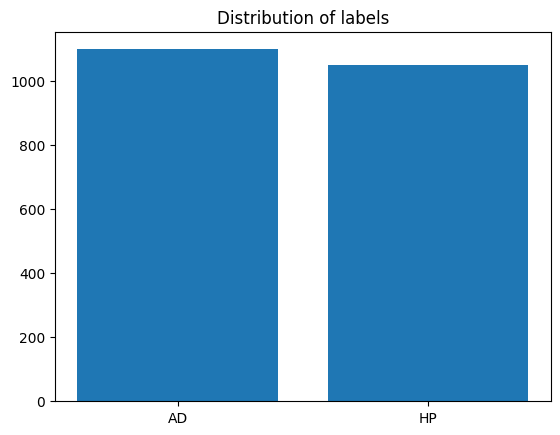

In [7]:
# num_pos, num_neg = len(pos_samples), len(neg_samples)

# plt.title("Distribution of labels")
# plt.bar(["COVID", "non-COVID"], [num_pos, num_neg])
# plt.show()

num_ad, num_hp = len(adenoma_files), len(hp_files)

plt.title("Distribution of labels")
plt.bar(["AD", "HP"], [num_ad, num_hp])
plt.show()

In [8]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        # image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        image = imread(samples[i])
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("AD", fontsize=20)
        else:
            ax[i//5][i%5].set_title("HP", fontsize=20)
        ax[i//5][i%5].axis('off')

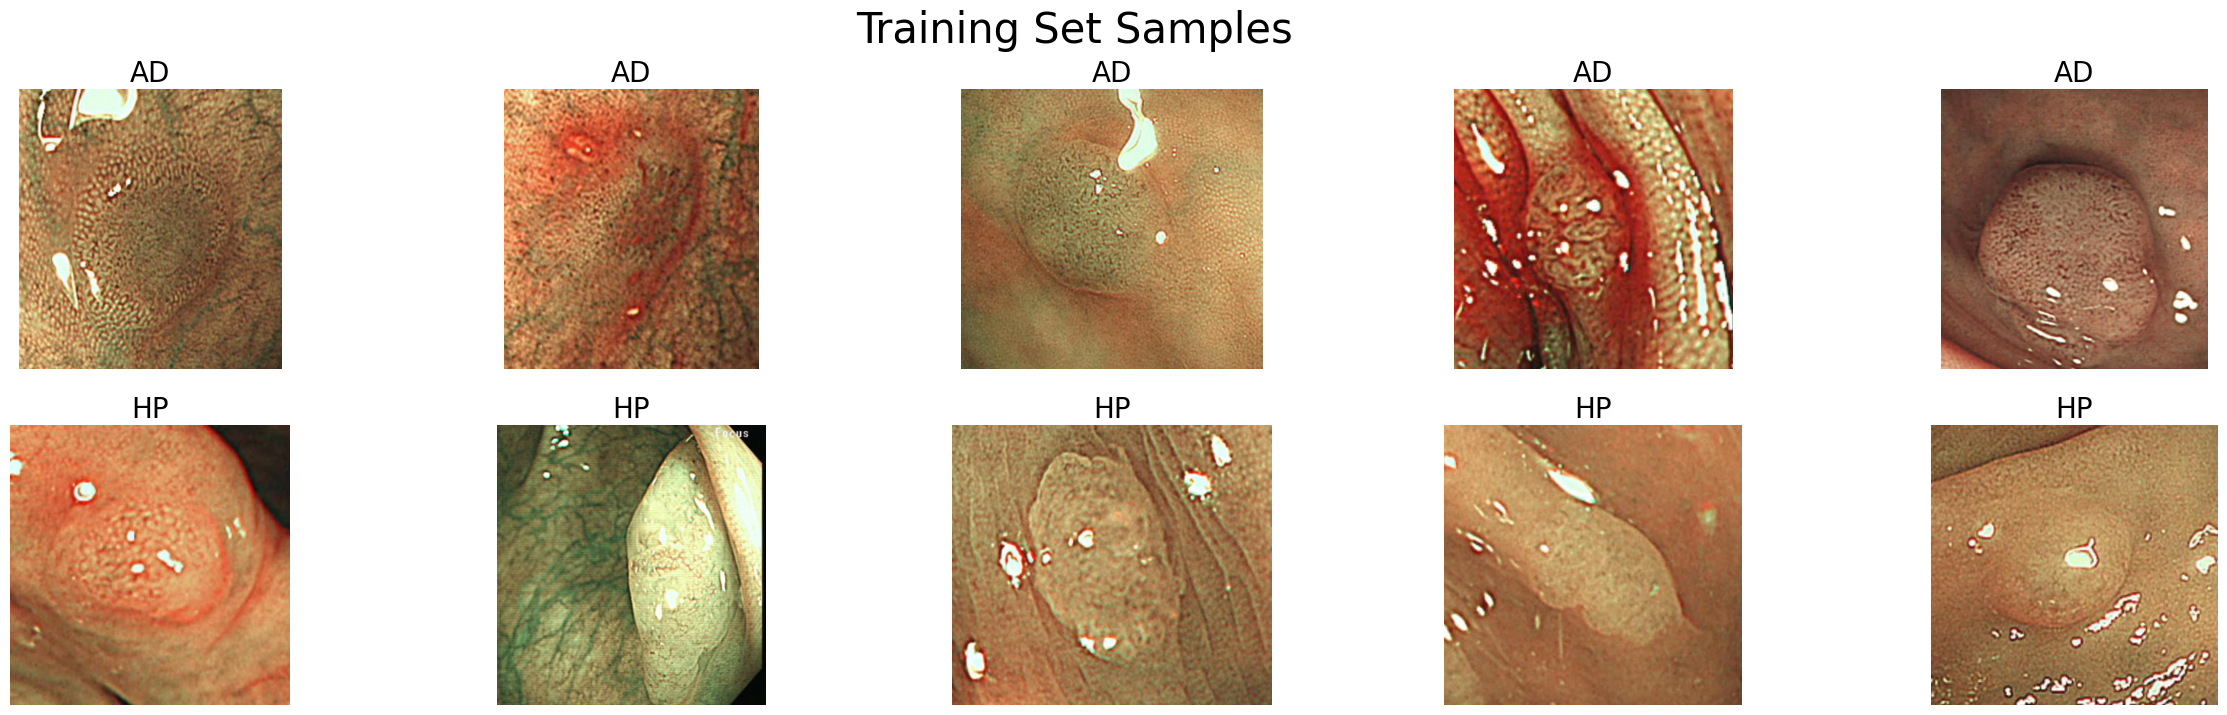

In [9]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/Train/AD', filename) 
                              for filename in os.listdir(data_dir+'/Train/AD')], 5) + \
    random.sample([os.path.join(data_dir+'/Train/HP', filename) 
                   for filename in os.listdir(data_dir+'/Train/HP')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

### Custom data loader

In [10]:
# pre-processing transformations
# data_transforms to return 3-channel input, e.g., RGB-image
# Note that given gray-image (e.g.,x-ray image) with 1-channel size, 
# it will return 3-channel input tensor 
# because  `DataLoader` uses a `pil_loader` which converts an input to RGB image 
# by using `img.convert('RGB')`
def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = T.Compose([
                T.Resize(size = (256, 256)),
                T.CenterCrop(size=224),
                T.RandomHorizontalFlip(),
                T.RandomRotation(10),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == TEST or phase == VAL:

        data_T = T.Compose([
                T.Resize(size = (256, 256), interpolation=3),
                T.CenterCrop(size=224),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

In [11]:
# check input tensor shape by using `data_gray_transforms`
# it is predicted to return 1-channel input tensor

TRAIN = 'Train'
VAL ='Ext_val/crop_ad_hp'
TEST = 'Test'
train_path = os.path.join(data_dir, TRAIN) # train data directory
train_set = ImageFolder(train_path, transform=data_transforms(TRAIN))

img, label = train_set[0]
print(img.shape, label)
print(train_set.classes)

torch.Size([3, 224, 224]) 0
['AD', 'HP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AD (0)


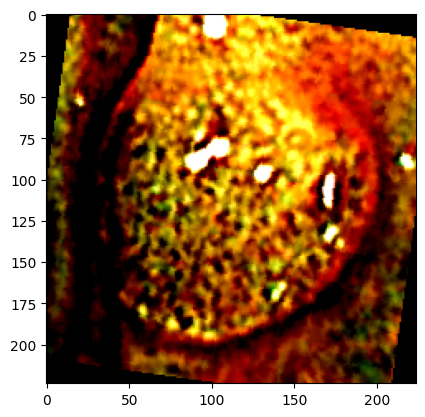

In [12]:
# display(transforms.ToPILImage()(train_set[3][0]))

def show_example(img, label):
    print("Label: ", train_set.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) # [C, H, W] -> [H, W, C] for matplotlib

show_example(*train_set[3])

In [13]:
# test_set = ImageFolder(os.path.join(data_dir, TEST), transform=data_gray_transforms(TEST)) # for 1-channel input tensor
val_set = ImageFolder(os.path.join(data_dir, VAL), transform=data_transforms(VAL)) # 3-channel input tensor
val_set
# print(val_set.classes)

/home/lsrock1/anaconda3/envs/pytorch1.9/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Dataset ImageFolder
    Number of datapoints: 372
    Root location: /home/lsrock1/data/polyp/Ext_val/crop_ad_hp
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size, shuffle=False, drop_last=False, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


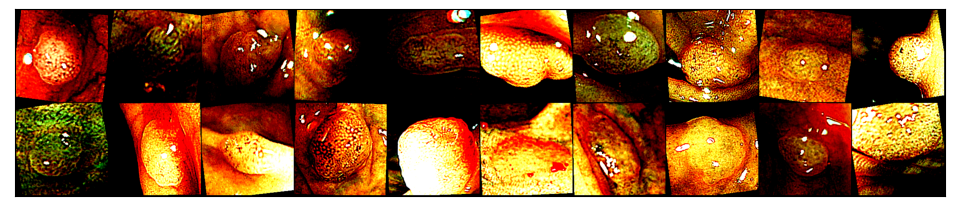

In [21]:
# Let's visualize a batch of data in a grid using the make_grid function from torchvision. 
# We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by matplotlib.

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:20], nrow=10).permute(1, 2, 0))
        break

show_batch(train_loader)

## Inception
Since `timm` models are implemented for multi-class classification (e.g., ImageNet-1K), we set `num_classes` to `2`, not `1`.

### from-scratch

In [84]:
import timm

# Load ResNet-50 model without the pre-trained weight
num_classes = 2
# model_name = 'vit_small_patch16_224'
model_name = 'inception_v3'
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

# hyperparamters
learning_rate = 1e-4
num_epochs = 100

In [23]:
def train_model(model_name, model, train_loader, test_loader, device, out_name=None,
                lr=0.0001, epochs=30, batch_size=32, weight_decay=0.05, gamma=0.5,
                patience=7):
    
    model = model.to(device)
    # history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    # set up loss function and optimizer
    # criterion = nn.BCEWithLogitsLoss().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)  # pass in the parameters to be updated and learning rate
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    # Training Loop
    max_acc = 0.
    best_epoch = 0
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0.
        val_loss = 0.
        val_acc = 0.

        for data in tqdm.tqdm(train_loader):
            
            inputs, labels = data[0].to(device), data[1].to(device)            
            optimizer.zero_grad()
            outputs = model(inputs)  # forward
            cur_train_loss = criterion(outputs, labels)  # loss

            # backward
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            
            # loss
            train_loss += cur_train_loss.item() 
            
        # validation
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            print("validation starts!")
            for data in tqdm.tqdm(test_loader):

                inputs, labels = data[0].to(device), data[1].to(device)            
                outputs = model(inputs)
                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss.item()

                _, preds = torch.max(outputs.data, dim=1) 
                cur_val = (preds == labels).sum().item() / labels.size(0)
                val_acc += cur_val
        
        scheduler.step() # learning schedule step
        
        # print training feedback
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(test_loader)
        val_acc = val_acc / len(test_loader)
        
        if val_acc > max_acc:
            # print save checkpoint
            if out_name:
                torch.save(model.state_dict(), f'{out_name}_best_model.pt')
            else:
                torch.save(model.state_dict(), f'{model_name}_best_model.pt')
            max_acc = val_acc
            best_epoch = epoch

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.6f} train loss:{train_loss:.5f}, val loss:{val_loss:.5f}, val acc:{val_acc:.5f}, max acc:{max_acc:.5f}")
    
        # update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]["lr"])
    
    print(f'best_epoch:{best_epoch}, best accuracy:{max_acc}')

    return history

In [86]:
out_name = f"{model_name}_from_scratch"
history = train_model(model_name, model, train_loader, val_loader, out_name=out_name, device=device, lr=learning_rate, epochs=num_epochs)

  0%|          | 0/34 [00:00<?, ?it/s]

Training Start:


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:1 / 100, lr: 0.000100 train loss:0.65614, val loss:0.77458, val acc:0.63702, max acc:0.63702


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:2 / 100, lr: 0.000100 train loss:0.51500, val loss:0.44739, val acc:0.79968, max acc:0.79968


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:3 / 100, lr: 0.000100 train loss:0.50963, val loss:0.50760, val acc:0.82853, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:4 / 100, lr: 0.000100 train loss:0.49435, val loss:0.63330, val acc:0.73938, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:5 / 100, lr: 0.000099 train loss:0.48010, val loss:0.54848, val acc:0.75200, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:6 / 100, lr: 0.000099 train loss:0.44702, val loss:0.48806, val acc:0.78526, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:7 / 100, lr: 0.000099 train loss:0.44855, val loss:0.74559, val acc:0.70232, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:8 / 100, lr: 0.000098 train loss:0.40130, val loss:0.45288, val acc:0.82632, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:9 / 100, lr: 0.000098 train loss:0.39527, val loss:0.53500, val acc:0.75982, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:10 / 100, lr: 0.000098 train loss:0.39791, val loss:0.58183, val acc:0.76242, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:11 / 100, lr: 0.000097 train loss:0.39060, val loss:0.49014, val acc:0.78165, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:12 / 100, lr: 0.000096 train loss:0.38015, val loss:0.52422, val acc:0.77825, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:13 / 100, lr: 0.000096 train loss:0.37232, val loss:0.51143, val acc:0.81170, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:14 / 100, lr: 0.000095 train loss:0.36192, val loss:0.65446, val acc:0.73478, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:15 / 100, lr: 0.000095 train loss:0.35046, val loss:0.49668, val acc:0.78586, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:16 / 100, lr: 0.000094 train loss:0.37139, val loss:0.49903, val acc:0.80529, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:17 / 100, lr: 0.000093 train loss:0.35725, val loss:0.56984, val acc:0.75641, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:18 / 100, lr: 0.000092 train loss:0.33321, val loss:0.62257, val acc:0.74159, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:19 / 100, lr: 0.000091 train loss:0.31834, val loss:0.49487, val acc:0.78786, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:20 / 100, lr: 0.000090 train loss:0.32261, val loss:0.53806, val acc:0.77424, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:21 / 100, lr: 0.000090 train loss:0.29051, val loss:0.55699, val acc:0.77965, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:22 / 100, lr: 0.000089 train loss:0.29209, val loss:0.58000, val acc:0.80228, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:23 / 100, lr: 0.000088 train loss:0.28491, val loss:0.55697, val acc:0.78666, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:24 / 100, lr: 0.000086 train loss:0.28128, val loss:1.01201, val acc:0.67969, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:25 / 100, lr: 0.000085 train loss:0.29754, val loss:0.52131, val acc:0.78866, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:26 / 100, lr: 0.000084 train loss:0.25113, val loss:0.58327, val acc:0.77564, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:27 / 100, lr: 0.000083 train loss:0.26404, val loss:0.52162, val acc:0.81010, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:28 / 100, lr: 0.000082 train loss:0.23122, val loss:0.50432, val acc:0.82031, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:29 / 100, lr: 0.000081 train loss:0.26966, val loss:0.63800, val acc:0.77404, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:30 / 100, lr: 0.000079 train loss:0.26552, val loss:0.60589, val acc:0.79087, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:31 / 100, lr: 0.000078 train loss:0.23004, val loss:0.57126, val acc:0.81530, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:32 / 100, lr: 0.000077 train loss:0.22724, val loss:0.61747, val acc:0.77804, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:33 / 100, lr: 0.000075 train loss:0.22532, val loss:0.69127, val acc:0.78706, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:34 / 100, lr: 0.000074 train loss:0.22886, val loss:0.66568, val acc:0.77744, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:35 / 100, lr: 0.000073 train loss:0.21883, val loss:0.76979, val acc:0.71995, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:36 / 100, lr: 0.000071 train loss:0.21552, val loss:0.74583, val acc:0.75841, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:37 / 100, lr: 0.000070 train loss:0.19420, val loss:0.70387, val acc:0.72476, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:38 / 100, lr: 0.000068 train loss:0.22659, val loss:0.74844, val acc:0.78486, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:39 / 100, lr: 0.000067 train loss:0.18036, val loss:0.66746, val acc:0.80108, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:40 / 100, lr: 0.000065 train loss:0.21021, val loss:0.69836, val acc:0.74499, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:41 / 100, lr: 0.000064 train loss:0.17285, val loss:0.77601, val acc:0.71174, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:42 / 100, lr: 0.000062 train loss:0.16767, val loss:0.70181, val acc:0.74679, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:43 / 100, lr: 0.000061 train loss:0.16983, val loss:0.61621, val acc:0.80308, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:44 / 100, lr: 0.000059 train loss:0.16496, val loss:0.68212, val acc:0.76863, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:45 / 100, lr: 0.000058 train loss:0.15620, val loss:0.76028, val acc:0.75721, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:46 / 100, lr: 0.000056 train loss:0.14727, val loss:0.70966, val acc:0.80809, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:47 / 100, lr: 0.000055 train loss:0.13578, val loss:0.85167, val acc:0.74659, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:48 / 100, lr: 0.000053 train loss:0.13453, val loss:0.66137, val acc:0.82171, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:49 / 100, lr: 0.000052 train loss:0.13878, val loss:0.77292, val acc:0.80409, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:50 / 100, lr: 0.000050 train loss:0.13359, val loss:0.73979, val acc:0.79708, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:51 / 100, lr: 0.000048 train loss:0.12834, val loss:0.81753, val acc:0.78005, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:52 / 100, lr: 0.000047 train loss:0.12160, val loss:0.76737, val acc:0.78606, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:53 / 100, lr: 0.000045 train loss:0.10444, val loss:0.82866, val acc:0.80729, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:54 / 100, lr: 0.000044 train loss:0.13748, val loss:0.78162, val acc:0.78786, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:55 / 100, lr: 0.000042 train loss:0.10693, val loss:0.82074, val acc:0.77624, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:56 / 100, lr: 0.000041 train loss:0.11656, val loss:0.80518, val acc:0.77764, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:57 / 100, lr: 0.000039 train loss:0.11304, val loss:0.87304, val acc:0.76062, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:58 / 100, lr: 0.000038 train loss:0.10107, val loss:0.87245, val acc:0.79908, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:59 / 100, lr: 0.000036 train loss:0.10061, val loss:0.90880, val acc:0.77304, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:60 / 100, lr: 0.000035 train loss:0.10446, val loss:0.99555, val acc:0.76763, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:61 / 100, lr: 0.000033 train loss:0.09355, val loss:0.97356, val acc:0.76823, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:62 / 100, lr: 0.000032 train loss:0.10273, val loss:0.94931, val acc:0.78125, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:63 / 100, lr: 0.000030 train loss:0.10705, val loss:1.00809, val acc:0.75841, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:64 / 100, lr: 0.000029 train loss:0.09313, val loss:0.97815, val acc:0.76502, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:65 / 100, lr: 0.000027 train loss:0.07455, val loss:1.04767, val acc:0.76222, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:66 / 100, lr: 0.000026 train loss:0.08281, val loss:1.00974, val acc:0.78506, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:67 / 100, lr: 0.000025 train loss:0.08244, val loss:0.98502, val acc:0.77544, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:68 / 100, lr: 0.000023 train loss:0.09329, val loss:0.85272, val acc:0.81971, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:69 / 100, lr: 0.000022 train loss:0.08879, val loss:0.99338, val acc:0.75321, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:70 / 100, lr: 0.000021 train loss:0.08037, val loss:0.93419, val acc:0.78706, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:71 / 100, lr: 0.000019 train loss:0.07923, val loss:0.94083, val acc:0.78506, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:72 / 100, lr: 0.000018 train loss:0.07034, val loss:0.88946, val acc:0.78245, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:73 / 100, lr: 0.000017 train loss:0.06724, val loss:0.85629, val acc:0.80469, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:74 / 100, lr: 0.000016 train loss:0.07509, val loss:0.84888, val acc:0.80068, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:75 / 100, lr: 0.000015 train loss:0.06560, val loss:1.00117, val acc:0.76222, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:76 / 100, lr: 0.000014 train loss:0.07104, val loss:0.87187, val acc:0.80329, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:77 / 100, lr: 0.000012 train loss:0.06964, val loss:1.01168, val acc:0.77784, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:78 / 100, lr: 0.000011 train loss:0.07712, val loss:1.02656, val acc:0.76623, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:79 / 100, lr: 0.000010 train loss:0.06228, val loss:0.94151, val acc:0.77684, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:80 / 100, lr: 0.000010 train loss:0.07066, val loss:0.95093, val acc:0.78325, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:81 / 100, lr: 0.000009 train loss:0.06582, val loss:0.98308, val acc:0.77544, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:82 / 100, lr: 0.000008 train loss:0.06052, val loss:0.96222, val acc:0.78385, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:83 / 100, lr: 0.000007 train loss:0.06445, val loss:0.91797, val acc:0.79107, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:84 / 100, lr: 0.000006 train loss:0.05852, val loss:0.95753, val acc:0.77664, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:85 / 100, lr: 0.000005 train loss:0.07589, val loss:0.94740, val acc:0.79167, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:86 / 100, lr: 0.000005 train loss:0.05246, val loss:0.98272, val acc:0.78646, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:87 / 100, lr: 0.000004 train loss:0.06382, val loss:0.94228, val acc:0.77985, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:88 / 100, lr: 0.000004 train loss:0.04712, val loss:0.94745, val acc:0.78506, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:89 / 100, lr: 0.000003 train loss:0.06207, val loss:0.91881, val acc:0.79367, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:90 / 100, lr: 0.000002 train loss:0.05368, val loss:0.96197, val acc:0.79167, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:91 / 100, lr: 0.000002 train loss:0.05793, val loss:0.95172, val acc:0.78906, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:92 / 100, lr: 0.000002 train loss:0.05809, val loss:0.93515, val acc:0.78646, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:93 / 100, lr: 0.000001 train loss:0.04606, val loss:0.99194, val acc:0.77604, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:94 / 100, lr: 0.000001 train loss:0.06201, val loss:1.00491, val acc:0.77464, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:95 / 100, lr: 0.000001 train loss:0.05706, val loss:1.02649, val acc:0.76943, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:96 / 100, lr: 0.000000 train loss:0.05271, val loss:0.93103, val acc:0.79427, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:97 / 100, lr: 0.000000 train loss:0.04335, val loss:0.96316, val acc:0.77664, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:98 / 100, lr: 0.000000 train loss:0.05382, val loss:0.92896, val acc:0.78906, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:99 / 100, lr: 0.000000 train loss:0.07528, val loss:0.95974, val acc:0.78446, max acc:0.82853


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

Epoch:100 / 100, lr: 0.000000 train loss:0.05701, val loss:0.98434, val acc:0.77664, max acc:0.82853
best_epoch:2, best accuracy:0.828525641025641


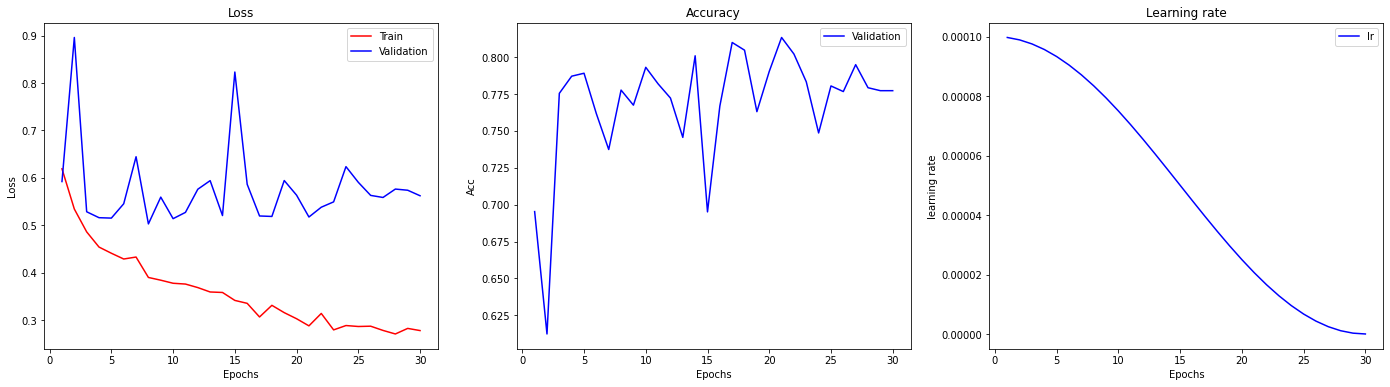

In [80]:
# plot training curves
epochs = range(1, len(history['train_loss']) + 1)

fig, ax = plt.subplots(1, 3, figsize=(24,6))
ax[0].plot(epochs, history['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, history['val_loss'], 'b-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history['val_acc'], 'b-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

ax[2].plot(epochs, history['lr'], 'b-', label='lr')
ax[2].set_title('Learning rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('learning rate')
ax[2].legend()

plt.show()

#### Evaluation with metrics

In [24]:
def metric_analysis(model, out_name, ckpt_path):
    
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt)
    
    test_acc = 0.
    y_pred_list = []
    y_target_list = []
    logs = {}

    model.eval()  # start to train the model, activate training behavior
    with torch.no_grad():  # tell pytorch not to update parameters
        print("Test starts!")
        for data in tqdm.tqdm(val_loader):

            inputs, labels = data[0].to(device), data[1].to(device)            
            outputs = model(inputs)

            _, preds = torch.max(outputs.data, dim=1) 
            cur_val = (preds == labels).sum().item() / labels.size(0)
            test_acc += cur_val
            
            y_pred_list.append(outputs)
            y_target_list.append(labels)
            
            final_acc = (test_acc / len(val_loader))

    print(f'\nTest Accuracy:  {final_acc}')

    y_pred_list = torch.cat(y_pred_list)
    y_target_list = torch.cat(y_target_list)

    auroc = AUROC(num_classes=2).to(device)
    cfmat = ConfusionMatrix(num_classes=2).to(device)

    auc_all = auroc(y_pred_list, y_target_list)
    print(f'AUROC: {auc_all:.4f}')
    logs['auc'] = auc_all.item()

    cfmat_all = cfmat(y_pred_list, y_target_list)
    TN, FP, FN, TP = cfmat_all[0][0], cfmat_all[0][1], cfmat_all[1][0], cfmat_all[1][1]

    print(f'TN:{cfmat_all[0][0]}, FP:{cfmat_all[0][1]}, FN:{cfmat_all[1][0]}, TP:{cfmat_all[1][1]}')

    accuracy = (TP + TN) / (TP+TN+FP+FN)
    print(f'acc.:{accuracy:.4f}')

    # Sensitivity -> TPR = TP / (TP + FN)
    TPR = TP/(TP + FN)
    print(f'Sensitivity: {TPR:.4f}')
    logs['Sensitivity'] = TPR.item()
    # Specificity -> TNR = TN / (TN + FP)
    TNR = TN/(TN + FP)
    print(f'Specificity: {TNR:.4f}')
    logs['Specificity'] = TNR.item()
    # Positive predictive value -> TP / (TP + FP) = Precision (PPV)
    PPV = TP/(TP + FP)
    print(f'Positive predictive value: {PPV:.4f}')
    logs['Positive predictive value'] = PPV.item()
    # negative predictive value -> TN / (TN + FN)
    NPV = TN/(TN + FN)
    print(f'Negative predictive value: {NPV:.4f}')
    logs['Negative predictive value'] = NPV.item()
    # F1-Score -> 2 x (PPV x TPR) / (PPV + TPR)
    f1_score = 2 * (PPV * TPR) / (PPV + TPR)
    print(f'F1-score: {f1_score:.4f}')
    logs['f1_score'] = f1_score.item()

    logs['Accuracy'] = final_acc

    import json
    with open(f"./{out_name}_metrics.txt", "w") as fp:
        json.dump(logs, fp)
    
    print(logs)


In [83]:
metric_analysis(model, out_name=out_name, ckpt_path=f'./{out_name}_best_model.pt')

  0%|          | 0/6 [00:00<?, ?it/s]

Test starts!


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]



Test Accuracy:  0.813301282051282
AUROC: 0.8228
TN:236, FP:42, FN:26, TP:68
acc.:0.8172
Sensitivity: 0.7234
Specificity: 0.8489
Positive predictive value: 0.6182
Negative predictive value: 0.9008
F1-score: 0.6667
{'auc': 0.8228417634963989, 'Sensitivity': 0.7234042286872864, 'Specificity': 0.8489208817481995, 'Positive predictive value': 0.6181818246841431, 'Negative predictive value': 0.9007633328437805, 'f1_score': 0.6666666269302368, 'Accuracy': 0.813301282051282}


/home/lsrock1/anaconda3/envs/pytorch1.7/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### using pre-trained weight

In [59]:
# Load ResNet-50 model without the pre-trained weight
num_classes = 2
# model_name = "convnext_small.in12k_ft_in1k"
model_name = 'inception_v3'
pt_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

In [60]:
# tune `learning_rate`
learning_rate = 0.0001
num_epochs = 100
out_name = f'{model_name}_pretrained'
history = train_model(model_name, pt_model, train_loader, val_loader, out_name=out_name, device=device, lr=learning_rate, epochs=num_epochs)

  0%|          | 0/34 [00:00<?, ?it/s]

Training Start:


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:1 / 100, lr: 0.000100 train loss:0.56345, val loss:0.45172, val acc:0.84976, max acc:0.84976


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:2 / 100, lr: 0.000100 train loss:0.26358, val loss:0.39049, val acc:0.85417, max acc:0.85417


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:3 / 100, lr: 0.000100 train loss:0.14695, val loss:0.39594, val acc:0.88982, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:4 / 100, lr: 0.000100 train loss:0.10715, val loss:0.42659, val acc:0.86979, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:5 / 100, lr: 0.000099 train loss:0.07531, val loss:0.42292, val acc:0.86258, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:6 / 100, lr: 0.000099 train loss:0.03936, val loss:0.42338, val acc:0.86899, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:7 / 100, lr: 0.000099 train loss:0.04111, val loss:0.42367, val acc:0.87540, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:8 / 100, lr: 0.000098 train loss:0.03281, val loss:0.56331, val acc:0.84555, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:9 / 100, lr: 0.000098 train loss:0.04095, val loss:0.57996, val acc:0.83554, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:10 / 100, lr: 0.000098 train loss:0.02942, val loss:0.57253, val acc:0.84135, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:11 / 100, lr: 0.000097 train loss:0.02866, val loss:0.58316, val acc:0.83514, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:12 / 100, lr: 0.000096 train loss:0.04255, val loss:0.48313, val acc:0.87280, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:13 / 100, lr: 0.000096 train loss:0.05407, val loss:0.48024, val acc:0.86639, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:14 / 100, lr: 0.000095 train loss:0.04441, val loss:0.64884, val acc:0.82913, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:15 / 100, lr: 0.000095 train loss:0.02305, val loss:0.65170, val acc:0.84235, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:16 / 100, lr: 0.000094 train loss:0.02377, val loss:0.70858, val acc:0.81891, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:17 / 100, lr: 0.000093 train loss:0.01994, val loss:0.70819, val acc:0.85457, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:18 / 100, lr: 0.000092 train loss:0.01475, val loss:0.53544, val acc:0.85917, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:19 / 100, lr: 0.000091 train loss:0.01569, val loss:0.96774, val acc:0.78726, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:20 / 100, lr: 0.000090 train loss:0.01826, val loss:0.64241, val acc:0.82993, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:21 / 100, lr: 0.000090 train loss:0.02092, val loss:0.82411, val acc:0.80369, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:22 / 100, lr: 0.000089 train loss:0.01175, val loss:0.49423, val acc:0.88401, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:23 / 100, lr: 0.000088 train loss:0.02209, val loss:0.60646, val acc:0.84215, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:24 / 100, lr: 0.000086 train loss:0.01224, val loss:0.57942, val acc:0.87881, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:25 / 100, lr: 0.000085 train loss:0.01284, val loss:0.71510, val acc:0.85537, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:26 / 100, lr: 0.000084 train loss:0.01276, val loss:1.19514, val acc:0.77384, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:27 / 100, lr: 0.000083 train loss:0.00975, val loss:0.76588, val acc:0.83834, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:28 / 100, lr: 0.000082 train loss:0.01728, val loss:0.81699, val acc:0.81550, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:29 / 100, lr: 0.000081 train loss:0.01138, val loss:0.72421, val acc:0.81430, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:30 / 100, lr: 0.000079 train loss:0.01201, val loss:0.71878, val acc:0.83313, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:31 / 100, lr: 0.000078 train loss:0.01201, val loss:0.70584, val acc:0.85196, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:32 / 100, lr: 0.000077 train loss:0.01396, val loss:0.74567, val acc:0.83894, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:33 / 100, lr: 0.000075 train loss:0.01390, val loss:0.73576, val acc:0.84876, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:34 / 100, lr: 0.000074 train loss:0.00959, val loss:0.61905, val acc:0.87821, max acc:0.88982


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:35 / 100, lr: 0.000073 train loss:0.00347, val loss:0.58047, val acc:0.90365, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:36 / 100, lr: 0.000071 train loss:0.00230, val loss:0.58222, val acc:0.89363, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:37 / 100, lr: 0.000070 train loss:0.00420, val loss:0.69118, val acc:0.88001, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:38 / 100, lr: 0.000068 train loss:0.00837, val loss:0.63886, val acc:0.87881, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:39 / 100, lr: 0.000067 train loss:0.01139, val loss:0.84221, val acc:0.82332, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:40 / 100, lr: 0.000065 train loss:0.00428, val loss:0.87318, val acc:0.80829, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:41 / 100, lr: 0.000064 train loss:0.00158, val loss:0.95658, val acc:0.78486, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:42 / 100, lr: 0.000062 train loss:0.00212, val loss:1.07792, val acc:0.75881, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:43 / 100, lr: 0.000061 train loss:0.00675, val loss:0.79512, val acc:0.83894, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:44 / 100, lr: 0.000059 train loss:0.00283, val loss:0.71973, val acc:0.85517, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:45 / 100, lr: 0.000058 train loss:0.00594, val loss:0.72558, val acc:0.84736, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:46 / 100, lr: 0.000056 train loss:0.00501, val loss:0.82567, val acc:0.82392, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:47 / 100, lr: 0.000055 train loss:0.00370, val loss:0.88468, val acc:0.80048, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:48 / 100, lr: 0.000053 train loss:0.00578, val loss:0.83315, val acc:0.82332, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:49 / 100, lr: 0.000052 train loss:0.00274, val loss:0.81380, val acc:0.81671, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:50 / 100, lr: 0.000050 train loss:0.00410, val loss:0.83419, val acc:0.81350, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:51 / 100, lr: 0.000048 train loss:0.00212, val loss:0.86454, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:52 / 100, lr: 0.000047 train loss:0.00167, val loss:0.98178, val acc:0.78806, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:53 / 100, lr: 0.000045 train loss:0.00191, val loss:0.93794, val acc:0.80369, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:54 / 100, lr: 0.000044 train loss:0.00073, val loss:0.96759, val acc:0.82332, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:55 / 100, lr: 0.000042 train loss:0.00087, val loss:1.01349, val acc:0.81410, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:56 / 100, lr: 0.000041 train loss:0.00040, val loss:0.94307, val acc:0.80829, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:57 / 100, lr: 0.000039 train loss:0.00221, val loss:0.87148, val acc:0.82392, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:58 / 100, lr: 0.000038 train loss:0.00082, val loss:0.78258, val acc:0.83954, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:59 / 100, lr: 0.000036 train loss:0.00089, val loss:0.73013, val acc:0.85777, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:60 / 100, lr: 0.000035 train loss:0.00132, val loss:0.76683, val acc:0.83694, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:61 / 100, lr: 0.000033 train loss:0.00048, val loss:0.76442, val acc:0.83954, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:62 / 100, lr: 0.000032 train loss:0.00073, val loss:0.79737, val acc:0.82131, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:63 / 100, lr: 0.000030 train loss:0.00212, val loss:0.90865, val acc:0.82452, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:64 / 100, lr: 0.000029 train loss:0.00144, val loss:0.79972, val acc:0.81671, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:65 / 100, lr: 0.000027 train loss:0.00313, val loss:0.91021, val acc:0.80308, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:66 / 100, lr: 0.000026 train loss:0.00172, val loss:0.83094, val acc:0.83494, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:67 / 100, lr: 0.000025 train loss:0.00454, val loss:0.94002, val acc:0.78546, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:68 / 100, lr: 0.000023 train loss:0.00098, val loss:0.83685, val acc:0.80369, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:69 / 100, lr: 0.000022 train loss:0.00071, val loss:0.83583, val acc:0.81150, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:70 / 100, lr: 0.000021 train loss:0.00015, val loss:0.77532, val acc:0.81871, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:71 / 100, lr: 0.000019 train loss:0.00035, val loss:0.86200, val acc:0.81410, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:72 / 100, lr: 0.000018 train loss:0.00032, val loss:0.76769, val acc:0.82712, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:73 / 100, lr: 0.000017 train loss:0.00044, val loss:0.85258, val acc:0.81150, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:74 / 100, lr: 0.000016 train loss:0.00046, val loss:0.73022, val acc:0.82392, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:75 / 100, lr: 0.000015 train loss:0.00044, val loss:0.88487, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:76 / 100, lr: 0.000014 train loss:0.00016, val loss:0.89276, val acc:0.80889, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:77 / 100, lr: 0.000012 train loss:0.00035, val loss:0.91032, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:78 / 100, lr: 0.000011 train loss:0.00017, val loss:0.92900, val acc:0.80108, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:79 / 100, lr: 0.000010 train loss:0.00020, val loss:0.84967, val acc:0.81410, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:80 / 100, lr: 0.000010 train loss:0.00088, val loss:0.88030, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:81 / 100, lr: 0.000009 train loss:0.00053, val loss:0.89491, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:82 / 100, lr: 0.000008 train loss:0.00370, val loss:0.97922, val acc:0.78546, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:83 / 100, lr: 0.000007 train loss:0.00250, val loss:0.88599, val acc:0.79587, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:84 / 100, lr: 0.000006 train loss:0.00038, val loss:0.90628, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:85 / 100, lr: 0.000005 train loss:0.00015, val loss:0.93939, val acc:0.79067, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:86 / 100, lr: 0.000005 train loss:0.00048, val loss:0.86818, val acc:0.81150, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:87 / 100, lr: 0.000004 train loss:0.00025, val loss:0.79428, val acc:0.81671, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:88 / 100, lr: 0.000004 train loss:0.00156, val loss:0.88192, val acc:0.80369, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:89 / 100, lr: 0.000003 train loss:0.00041, val loss:0.85647, val acc:0.80629, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:90 / 100, lr: 0.000002 train loss:0.00021, val loss:0.93179, val acc:0.79067, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:91 / 100, lr: 0.000002 train loss:0.00011, val loss:0.82180, val acc:0.82452, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:92 / 100, lr: 0.000002 train loss:0.00043, val loss:0.96286, val acc:0.79327, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:93 / 100, lr: 0.000001 train loss:0.00032, val loss:1.03080, val acc:0.77764, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:94 / 100, lr: 0.000001 train loss:0.00014, val loss:0.98146, val acc:0.78806, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:95 / 100, lr: 0.000001 train loss:0.00031, val loss:0.81818, val acc:0.81931, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:96 / 100, lr: 0.000000 train loss:0.00008, val loss:0.84242, val acc:0.81931, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:97 / 100, lr: 0.000000 train loss:0.00017, val loss:0.86130, val acc:0.80889, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:98 / 100, lr: 0.000000 train loss:0.00051, val loss:0.84515, val acc:0.81410, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:99 / 100, lr: 0.000000 train loss:0.00096, val loss:0.96535, val acc:0.78285, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

Epoch:100 / 100, lr: 0.000000 train loss:0.00244, val loss:0.94671, val acc:0.78546, max acc:0.90365
best_epoch:34, best accuracy:0.9036458333333334


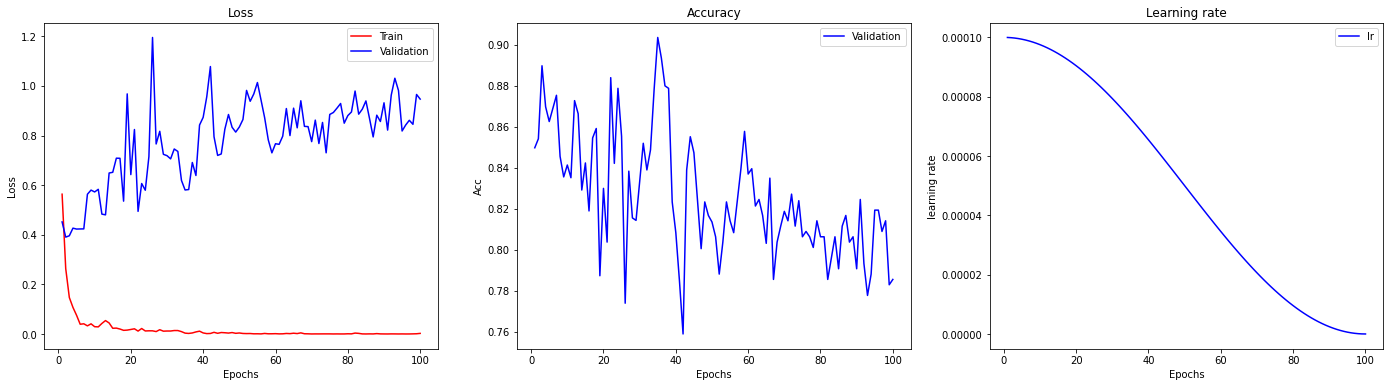

In [61]:
# plot training curves
epochs = range(1, len(history['train_loss']) + 1)

fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].plot(epochs, history['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, history['val_loss'], 'b-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history['val_acc'], 'b-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

ax[2].plot(epochs, history['lr'], 'b-', label='lr')
ax[2].set_title('Learning rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('learning rate')
ax[2].legend()

plt.show()

In [63]:
metric_analysis(model, out_name=out_name, ckpt_path=f'./{out_name}_best_model.pt')

<All keys matched successfully>

## MPViT

In [27]:
# !pip install einops

### Note
for now, during 30 epochs, with `drop_path_rate 0.05` yields 92.748% while `no_dpr` outputs 91.446
- settings: LR scheduler: `torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma)`

### `drop-path=rate=0.05`

In [19]:
from mpvit import mpvit_small
num_classes = 2
num_epochs = 30
# model_name = "convnext_small.in12k_ft_in1k"
model_name = "mpvit_small"
drop_path_rate = 0.05
model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)

In [47]:
# pretrained_weight = "https://dl.dropbox.com/s/la8w31m0apj2830/mpvit_base.pth"
pretrained_weight = "/home/lsrock1/deep_learning_tutorial_pytorch/mpvit_small.pth"


if pretrained_weight:
    if pretrained_weight.startswith("https"):
        checkpoint = torch.hub.load_state_dict_from_url(
            pretrained_weight, map_location="cpu", check_hash=True
        )
    else:
        checkpoint = torch.load(pretrained_weight, map_location="cpu")


checkpoint_state_dict = checkpoint["model"]
model_state_dict = model.state_dict()
for k in ['cls_head.cls.weight', 'cls_head.cls.bias']:
    if k in checkpoint_state_dict and checkpoint_state_dict[k].shape != model_state_dict[k].shape:
        print(f"Skip loading parameter:{k},"
                f"required shape: {model_state_dict[k].shape},"
                f"loaded shape: {checkpoint_state_dict[k].shape}")
        del checkpoint_state_dict[k]
model.load_state_dict(checkpoint_state_dict, strict=False)

Skip loading parameter:cls_head.cls.weight,required shape: torch.Size([2, 288]),loaded shape: torch.Size([1000, 288])
Skip loading parameter:cls_head.cls.bias,required shape: torch.Size([2]),loaded shape: torch.Size([1000])


_IncompatibleKeys(missing_keys=['cls_head.cls.weight', 'cls_head.cls.bias'], unexpected_keys=[])

In [48]:
# tune `learning_rate`
learning_rate = 0.0001
num_epochs = 100
history = train_model(f'{model_name}_{drop_path_rate}', model, train_loader, val_loader, device=device, lr=learning_rate,patience=10, epochs=num_epochs)

  0%|          | 0/34 [00:00<?, ?it/s]

Training Start:


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:1 / 100, lr: 0.000100 train loss:0.41745, val loss:0.29542, val acc:0.86819, max acc:0.86819


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:2 / 100, lr: 0.000100 train loss:0.20414, val loss:0.53300, val acc:0.76643, max acc:0.86819


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:3 / 100, lr: 0.000100 train loss:0.13762, val loss:0.36324, val acc:0.84736, max acc:0.86819


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:4 / 100, lr: 0.000100 train loss:0.10406, val loss:0.32040, val acc:0.88522, max acc:0.88522


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:5 / 100, lr: 0.000099 train loss:0.05639, val loss:0.25980, val acc:0.90365, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:6 / 100, lr: 0.000099 train loss:0.04172, val loss:0.40426, val acc:0.87159, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:7 / 100, lr: 0.000099 train loss:0.03268, val loss:0.42525, val acc:0.85637, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:8 / 100, lr: 0.000098 train loss:0.03220, val loss:0.41436, val acc:0.89864, max acc:0.90365


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:9 / 100, lr: 0.000098 train loss:0.04087, val loss:0.31631, val acc:0.91106, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:10 / 100, lr: 0.000098 train loss:0.02900, val loss:0.41971, val acc:0.85056, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:11 / 100, lr: 0.000097 train loss:0.02729, val loss:0.43576, val acc:0.88442, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:12 / 100, lr: 0.000096 train loss:0.01796, val loss:0.48904, val acc:0.85517, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:13 / 100, lr: 0.000096 train loss:0.00930, val loss:0.52788, val acc:0.84796, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:14 / 100, lr: 0.000095 train loss:0.01574, val loss:0.40489, val acc:0.89784, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:15 / 100, lr: 0.000095 train loss:0.01481, val loss:0.49618, val acc:0.87800, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:16 / 100, lr: 0.000094 train loss:0.00951, val loss:0.67370, val acc:0.82712, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:17 / 100, lr: 0.000093 train loss:0.00820, val loss:0.67801, val acc:0.84555, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:18 / 100, lr: 0.000092 train loss:0.01195, val loss:0.49232, val acc:0.86879, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:19 / 100, lr: 0.000091 train loss:0.00653, val loss:0.77522, val acc:0.80629, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:20 / 100, lr: 0.000090 train loss:0.02078, val loss:0.47291, val acc:0.89423, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:21 / 100, lr: 0.000090 train loss:0.02507, val loss:0.49774, val acc:0.88542, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:22 / 100, lr: 0.000089 train loss:0.02135, val loss:0.57358, val acc:0.88542, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:23 / 100, lr: 0.000088 train loss:0.03369, val loss:0.37515, val acc:0.90405, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:24 / 100, lr: 0.000086 train loss:0.01701, val loss:0.42403, val acc:0.90024, max acc:0.91106


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:25 / 100, lr: 0.000085 train loss:0.00642, val loss:0.40575, val acc:0.91587, max acc:0.91587


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:26 / 100, lr: 0.000084 train loss:0.00680, val loss:0.44896, val acc:0.91146, max acc:0.91587


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:27 / 100, lr: 0.000083 train loss:0.00506, val loss:0.48046, val acc:0.89303, max acc:0.91587


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:28 / 100, lr: 0.000082 train loss:0.00426, val loss:0.44177, val acc:0.89824, max acc:0.91587


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:29 / 100, lr: 0.000081 train loss:0.00126, val loss:0.43774, val acc:0.91847, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:30 / 100, lr: 0.000079 train loss:0.00093, val loss:0.43546, val acc:0.91326, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:31 / 100, lr: 0.000078 train loss:0.00170, val loss:0.44960, val acc:0.91647, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:32 / 100, lr: 0.000077 train loss:0.00382, val loss:0.51698, val acc:0.89303, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:33 / 100, lr: 0.000075 train loss:0.00118, val loss:0.47259, val acc:0.89503, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:34 / 100, lr: 0.000074 train loss:0.00071, val loss:0.46177, val acc:0.91587, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:35 / 100, lr: 0.000073 train loss:0.00046, val loss:0.47017, val acc:0.91847, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:36 / 100, lr: 0.000071 train loss:0.00059, val loss:0.48926, val acc:0.90284, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:37 / 100, lr: 0.000070 train loss:0.00747, val loss:0.50918, val acc:0.89824, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:38 / 100, lr: 0.000068 train loss:0.00329, val loss:0.50147, val acc:0.90144, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:39 / 100, lr: 0.000067 train loss:0.00564, val loss:0.49845, val acc:0.89904, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:40 / 100, lr: 0.000065 train loss:0.00313, val loss:0.57695, val acc:0.91607, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:41 / 100, lr: 0.000064 train loss:0.00529, val loss:0.51936, val acc:0.91607, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:42 / 100, lr: 0.000062 train loss:0.01045, val loss:0.47687, val acc:0.91066, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:43 / 100, lr: 0.000061 train loss:0.01463, val loss:0.46546, val acc:0.89223, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:44 / 100, lr: 0.000059 train loss:0.00304, val loss:0.44019, val acc:0.91246, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:45 / 100, lr: 0.000058 train loss:0.01149, val loss:0.43133, val acc:0.91326, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:46 / 100, lr: 0.000056 train loss:0.00390, val loss:0.44572, val acc:0.90525, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:47 / 100, lr: 0.000055 train loss:0.00119, val loss:0.45504, val acc:0.91707, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:48 / 100, lr: 0.000053 train loss:0.00134, val loss:0.52097, val acc:0.88642, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:49 / 100, lr: 0.000052 train loss:0.00319, val loss:0.49069, val acc:0.91707, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:50 / 100, lr: 0.000050 train loss:0.00234, val loss:0.49199, val acc:0.90865, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:51 / 100, lr: 0.000048 train loss:0.00783, val loss:0.51756, val acc:0.89363, max acc:0.91847


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:52 / 100, lr: 0.000047 train loss:0.00420, val loss:0.41132, val acc:0.92288, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:53 / 100, lr: 0.000045 train loss:0.00088, val loss:0.44181, val acc:0.90925, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:54 / 100, lr: 0.000044 train loss:0.00053, val loss:0.45793, val acc:0.91967, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:55 / 100, lr: 0.000042 train loss:0.00164, val loss:0.49601, val acc:0.90925, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:56 / 100, lr: 0.000041 train loss:0.00832, val loss:0.54748, val acc:0.91667, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:57 / 100, lr: 0.000039 train loss:0.00787, val loss:0.50310, val acc:0.90304, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:58 / 100, lr: 0.000038 train loss:0.00322, val loss:0.38196, val acc:0.91647, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:59 / 100, lr: 0.000036 train loss:0.00226, val loss:0.36404, val acc:0.91647, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:60 / 100, lr: 0.000035 train loss:0.00094, val loss:0.41546, val acc:0.91907, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:61 / 100, lr: 0.000033 train loss:0.00127, val loss:0.43392, val acc:0.91647, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:62 / 100, lr: 0.000032 train loss:0.00036, val loss:0.43253, val acc:0.91386, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:63 / 100, lr: 0.000030 train loss:0.00040, val loss:0.42357, val acc:0.91647, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:64 / 100, lr: 0.000029 train loss:0.00037, val loss:0.43322, val acc:0.91647, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:65 / 100, lr: 0.000027 train loss:0.00088, val loss:0.41390, val acc:0.91386, max acc:0.92288


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:66 / 100, lr: 0.000026 train loss:0.00064, val loss:0.39959, val acc:0.92428, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:67 / 100, lr: 0.000025 train loss:0.00091, val loss:0.40568, val acc:0.90865, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:68 / 100, lr: 0.000023 train loss:0.00035, val loss:0.42796, val acc:0.90665, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:69 / 100, lr: 0.000022 train loss:0.00077, val loss:0.42026, val acc:0.91126, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:70 / 100, lr: 0.000021 train loss:0.00056, val loss:0.44663, val acc:0.91186, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:71 / 100, lr: 0.000019 train loss:0.00022, val loss:0.45623, val acc:0.90605, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:72 / 100, lr: 0.000018 train loss:0.00019, val loss:0.45625, val acc:0.91186, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:73 / 100, lr: 0.000017 train loss:0.00063, val loss:0.47309, val acc:0.90665, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:74 / 100, lr: 0.000016 train loss:0.00027, val loss:0.47088, val acc:0.90405, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:75 / 100, lr: 0.000015 train loss:0.00035, val loss:0.45424, val acc:0.91907, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:76 / 100, lr: 0.000014 train loss:0.00019, val loss:0.45629, val acc:0.91386, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:77 / 100, lr: 0.000012 train loss:0.00020, val loss:0.45765, val acc:0.91126, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:78 / 100, lr: 0.000011 train loss:0.00022, val loss:0.45600, val acc:0.91386, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:79 / 100, lr: 0.000010 train loss:0.00023, val loss:0.46677, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:80 / 100, lr: 0.000010 train loss:0.00015, val loss:0.46291, val acc:0.91126, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:81 / 100, lr: 0.000009 train loss:0.00020, val loss:0.46999, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:82 / 100, lr: 0.000008 train loss:0.00043, val loss:0.46968, val acc:0.91126, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:83 / 100, lr: 0.000007 train loss:0.00014, val loss:0.46442, val acc:0.91907, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:84 / 100, lr: 0.000006 train loss:0.00015, val loss:0.46253, val acc:0.91386, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:85 / 100, lr: 0.000005 train loss:0.00110, val loss:0.47870, val acc:0.92167, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:86 / 100, lr: 0.000005 train loss:0.00032, val loss:0.48047, val acc:0.91386, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:87 / 100, lr: 0.000004 train loss:0.00030, val loss:0.48219, val acc:0.90665, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:88 / 100, lr: 0.000004 train loss:0.00026, val loss:0.47700, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:89 / 100, lr: 0.000003 train loss:0.00024, val loss:0.47929, val acc:0.91386, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:90 / 100, lr: 0.000002 train loss:0.00271, val loss:0.47203, val acc:0.91907, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:91 / 100, lr: 0.000002 train loss:0.00019, val loss:0.46804, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:92 / 100, lr: 0.000002 train loss:0.00023, val loss:0.47261, val acc:0.91126, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:93 / 100, lr: 0.000001 train loss:0.00032, val loss:0.46712, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:94 / 100, lr: 0.000001 train loss:0.00016, val loss:0.47120, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:95 / 100, lr: 0.000001 train loss:0.00028, val loss:0.47621, val acc:0.92167, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:96 / 100, lr: 0.000000 train loss:0.00016, val loss:0.47179, val acc:0.92167, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:97 / 100, lr: 0.000000 train loss:0.00057, val loss:0.46993, val acc:0.91907, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:98 / 100, lr: 0.000000 train loss:0.00030, val loss:0.46904, val acc:0.91907, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch:99 / 100, lr: 0.000000 train loss:0.00031, val loss:0.47102, val acc:0.91647, max acc:0.92428


  0%|          | 0/6 [00:00<?, ?it/s]

validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

Epoch:100 / 100, lr: 0.000000 train loss:0.00040, val loss:0.46784, val acc:0.91386, max acc:0.92428
best_epoch:65, best accuracy:0.9242788461538461


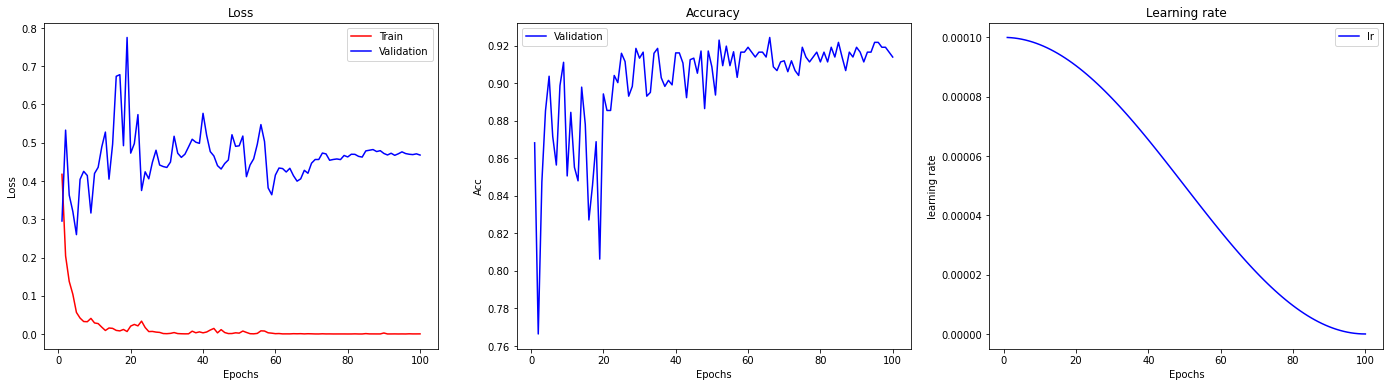

In [49]:
# plot training curves
epochs = range(1, len(history['train_loss']) + 1)

fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].plot(epochs, history['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, history['val_loss'], 'b-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history['val_acc'], 'b-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

ax[2].plot(epochs, history['lr'], 'b-', label='lr')
ax[2].set_title('Learning rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('learning rate')
ax[2].legend()

plt.show()

In [50]:
ckpt = torch.load(f"./mpvit_small_{drop_path_rate}_best_model.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [51]:
test_acc = 0.
y_pred_list = []
y_target_list = []

model.eval()  # start to train the model, activate training behavior
with torch.no_grad():  # tell pytorch not to update parameters
    print("Test starts!")
    for data in tqdm.tqdm(val_loader):

        inputs, labels = data[0].to(device), data[1].to(device)            
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, dim=1) 
        cur_val = (preds == labels).sum().item() / labels.size(0)
        test_acc += cur_val
        
        y_pred_list.append(outputs)
        y_target_list.append(labels)

print(f'\nTest Accuracy:  {(test_acc / len(val_loader))}')

y_pred_list = torch.cat(y_pred_list)
y_target_list = torch.cat(y_target_list)

  0%|          | 0/6 [00:00<?, ?it/s]

Test starts!


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Test Accuracy:  0.9242788461538461


In [52]:
test_acc = 0.
y_pred_list = []
y_target_list = []

model.eval()  # start to train the model, activate training behavior
with torch.no_grad():  # tell pytorch not to update parameters
    print("Test starts!")
    for data in tqdm.tqdm(val_loader):

        inputs, labels = data[0].to(device), data[1].to(device)            
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, dim=1) 
        cur_val = (preds == labels).sum().item() / labels.size(0)
        test_acc += cur_val
        
        y_pred_list.append(outputs)
        y_target_list.append(labels)

print(f'\nTest Accuracy:  {(test_acc / len(val_loader))}')

y_pred_list = torch.cat(y_pred_list)
y_target_list = torch.cat(y_target_list)

auroc = AUROC(num_classes=2).to(device)
cfmat = ConfusionMatrix(num_classes=2).to(device)

auc_all = auroc(y_pred_list, y_target_list)
print(f'AUROC: {auc_all:.4f}')

cfmat_all = cfmat(y_pred_list, y_target_list)
TN, FP, FN, TP = cfmat_all[0][0], cfmat_all[0][1], cfmat_all[1][0], cfmat_all[1][1]

print(f'TN:{cfmat_all[0][0]}, FP:{cfmat_all[0][1]}, FN:{cfmat_all[1][0]}, TP:{cfmat_all[1][1]}')

accuracy = (TP + TN) / (TP+TN+FP+FN)
print(f'acc.:{accuracy:.4f}')

# Sensitivity -> TPR = TP / (TP + FN)
TPR = TP/(TP + FN)
print(f'Sensitivity: {TPR:.4f}')
# Specificity -> TNR = TN / (TN + FP)
TNR = TN/(TN + FP)
print(f'Specificity: {TNR:.4f}')
# Positive predictive value -> TP / (TP + FP) = Precision (PPV)
PPV = TP/(TP + FP)
print(f'Positive predictive value: {PPV:.4f}')
# negative predictive value -> TN / (TN + FN)
NPV = TN/(TN + FN)
print(f'Negative predictive value: {NPV:.4f}')
# F1-Score -> 2 x (PPV x TPR) / (PPV + TPR)
f1_score = 2 * (PPV * TPR) / (PPV + TPR)
print(f'F1-score: {f1_score:.4f}')

  0%|          | 0/6 [00:00<?, ?it/s]

Test starts!


100%|██████████| 6/6 [00:02<00:00,  2.88it/s]


Test Accuracy:  0.9242788461538461
AUROC: 0.9590
TN:269, FP:9, FN:18, TP:76
acc.:0.9274
Sensitivity: 0.8085
Specificity: 0.9676
Positive predictive value: 0.8941
Negative predictive value: 0.9373
F1-score: 0.8492



/home/lsrock1/anaconda3/envs/pytorch1.7/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


#### `drop-path-rate=0.0`

In [20]:
from mpvit import mpvit_small

model_name = "mpvit_small"
drop_path_rate = 0.0
drop_rate = 0.3
# model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)
model = mpvit_small(num_classes=2, drop_path_rate=drop_path_rate, drop_rate=drop_rate)
# pretrained_weight = "https://dl.dropbox.com/s/la8w31m0apj2830/mpvit_base.pth"
pretrained_weight = "/home/lsrock1/deep_learning_tutorial_pytorch/mpvit_small.pth"
if pretrained_weight:
    if pretrained_weight.startswith("https"):
        checkpoint = torch.hub.load_state_dict_from_url(
            pretrained_weight, map_location="cpu", check_hash=True
        )
    else:
        checkpoint = torch.load(pretrained_weight, map_location="cpu")
checkpoint_state_dict = checkpoint["model"]
model_state_dict = model.state_dict()
for k in ['cls_head.cls.weight', 'cls_head.cls.bias']:
    if k in checkpoint_state_dict and checkpoint_state_dict[k].shape != model_state_dict[k].shape:
        print(f"Skip loading parameter:{k},"
                f"required shape: {model_state_dict[k].shape},"
                f"loaded shape: {checkpoint_state_dict[k].shape}")
        del checkpoint_state_dict[k]
model.load_state_dict(checkpoint_state_dict, strict=False)


# tune `learning_rate`
learning_rate = 0.0001
num_epochs = 100
# history = train_model(f'{model_name}_{drop_path_rate}', model, train_loader, val_loader, device=device, lr=learning_rate, patience=10, epochs=num_epochs)
out_name = f"{model_name}_{drop_path_rate}_dropout_{drop_rate}_pretrained"
history = train_model(model_name, model, train_loader, val_loader, out_name=out_name, device=device, lr=learning_rate, epochs=num_epochs)

metric_analysis(model, out_name=out_name, ckpt_path=f'./{out_name}_best_model.pt')


Skip loading parameter:cls_head.cls.weight,required shape: torch.Size([2, 288]),loaded shape: torch.Size([1000, 288])
Skip loading parameter:cls_head.cls.bias,required shape: torch.Size([2]),loaded shape: torch.Size([1000])


Training Start:


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:1 / 100, lr: 0.000100 train loss:0.39882, val loss:0.29741, val acc:0.89603, max acc:0.89603


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:2 / 100, lr: 0.000100 train loss:0.18625, val loss:0.28634, val acc:0.88922, max acc:0.89603


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:3 / 100, lr: 0.000100 train loss:0.11715, val loss:0.29570, val acc:0.87961, max acc:0.89603


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:4 / 100, lr: 0.000100 train loss:0.05783, val loss:0.32066, val acc:0.89784, max acc:0.89784


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch:5 / 100, lr: 0.000099 train loss:0.05554, val loss:0.35889, val acc:0.87680, max acc:0.89784


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch:6 / 100, lr: 0.000099 train loss:0.04393, val loss:0.37163, val acc:0.88021, max acc:0.89784


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:7 / 100, lr: 0.000099 train loss:0.03211, val loss:0.34801, val acc:0.87560, max acc:0.89784


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:8 / 100, lr: 0.000098 train loss:0.02253, val loss:0.40746, val acc:0.84615, max acc:0.89784


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:9 / 100, lr: 0.000098 train loss:0.01582, val loss:0.39319, val acc:0.91647, max acc:0.91647


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:10 / 100, lr: 0.000098 train loss:0.01578, val loss:0.55854, val acc:0.86298, max acc:0.91647


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.88it/s]


Epoch:11 / 100, lr: 0.000097 train loss:0.04114, val loss:0.75183, val acc:0.78405, max acc:0.91647


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:12 / 100, lr: 0.000096 train loss:0.03054, val loss:0.34713, val acc:0.90345, max acc:0.91647


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:13 / 100, lr: 0.000096 train loss:0.01712, val loss:0.35672, val acc:0.90946, max acc:0.91647


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:14 / 100, lr: 0.000095 train loss:0.00670, val loss:0.37785, val acc:0.90925, max acc:0.91647


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:15 / 100, lr: 0.000095 train loss:0.00456, val loss:0.38559, val acc:0.92248, max acc:0.92248


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:16 / 100, lr: 0.000094 train loss:0.00368, val loss:0.38812, val acc:0.92548, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:17 / 100, lr: 0.000093 train loss:0.00339, val loss:0.46035, val acc:0.91126, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:18 / 100, lr: 0.000092 train loss:0.00183, val loss:0.48686, val acc:0.88902, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:19 / 100, lr: 0.000091 train loss:0.00629, val loss:0.90757, val acc:0.77564, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:20 / 100, lr: 0.000090 train loss:0.02548, val loss:0.36851, val acc:0.91146, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:21 / 100, lr: 0.000090 train loss:0.01958, val loss:0.44751, val acc:0.89643, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:22 / 100, lr: 0.000089 train loss:0.01139, val loss:0.50045, val acc:0.88602, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:23 / 100, lr: 0.000088 train loss:0.01402, val loss:0.51392, val acc:0.88622, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:24 / 100, lr: 0.000086 train loss:0.01324, val loss:0.67878, val acc:0.82592, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:25 / 100, lr: 0.000085 train loss:0.02926, val loss:0.45037, val acc:0.89203, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:26 / 100, lr: 0.000084 train loss:0.01322, val loss:0.36902, val acc:0.90565, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:27 / 100, lr: 0.000083 train loss:0.00305, val loss:0.46882, val acc:0.89083, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:28 / 100, lr: 0.000082 train loss:0.00284, val loss:0.49530, val acc:0.90184, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:29 / 100, lr: 0.000081 train loss:0.00130, val loss:0.46587, val acc:0.89724, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:30 / 100, lr: 0.000079 train loss:0.00076, val loss:0.45493, val acc:0.90825, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:31 / 100, lr: 0.000078 train loss:0.00058, val loss:0.47006, val acc:0.90565, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:32 / 100, lr: 0.000077 train loss:0.00079, val loss:0.48081, val acc:0.90745, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch:33 / 100, lr: 0.000075 train loss:0.00195, val loss:0.55448, val acc:0.90044, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:34 / 100, lr: 0.000074 train loss:0.00193, val loss:0.61892, val acc:0.89203, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:35 / 100, lr: 0.000073 train loss:0.00139, val loss:0.59464, val acc:0.88662, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:36 / 100, lr: 0.000071 train loss:0.00086, val loss:0.55444, val acc:0.89523, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:37 / 100, lr: 0.000070 train loss:0.00156, val loss:0.57808, val acc:0.88221, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:38 / 100, lr: 0.000068 train loss:0.00079, val loss:0.52576, val acc:0.90224, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:39 / 100, lr: 0.000067 train loss:0.00035, val loss:0.55972, val acc:0.89583, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:40 / 100, lr: 0.000065 train loss:0.00037, val loss:0.64059, val acc:0.88081, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:41 / 100, lr: 0.000064 train loss:0.00045, val loss:0.64202, val acc:0.88602, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:42 / 100, lr: 0.000062 train loss:0.00112, val loss:0.75367, val acc:0.88421, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:43 / 100, lr: 0.000061 train loss:0.00476, val loss:0.48722, val acc:0.90685, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:44 / 100, lr: 0.000059 train loss:0.00700, val loss:0.77674, val acc:0.87480, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:45 / 100, lr: 0.000058 train loss:0.00420, val loss:0.43569, val acc:0.89243, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:46 / 100, lr: 0.000056 train loss:0.00607, val loss:0.57927, val acc:0.89203, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch:47 / 100, lr: 0.000055 train loss:0.00477, val loss:0.61373, val acc:0.86058, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:48 / 100, lr: 0.000053 train loss:0.00990, val loss:0.46503, val acc:0.89683, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:49 / 100, lr: 0.000052 train loss:0.00120, val loss:0.42020, val acc:0.90465, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:50 / 100, lr: 0.000050 train loss:0.00105, val loss:0.43134, val acc:0.91246, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:51 / 100, lr: 0.000048 train loss:0.00050, val loss:0.44935, val acc:0.90665, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:52 / 100, lr: 0.000047 train loss:0.00075, val loss:0.44803, val acc:0.90665, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:53 / 100, lr: 0.000045 train loss:0.00389, val loss:1.01812, val acc:0.85617, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:54 / 100, lr: 0.000044 train loss:0.00219, val loss:0.48586, val acc:0.90545, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:55 / 100, lr: 0.000042 train loss:0.00317, val loss:0.48867, val acc:0.91266, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:56 / 100, lr: 0.000041 train loss:0.00374, val loss:0.46562, val acc:0.90685, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:57 / 100, lr: 0.000039 train loss:0.00152, val loss:0.43003, val acc:0.91587, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:58 / 100, lr: 0.000038 train loss:0.00120, val loss:0.49916, val acc:0.91146, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:59 / 100, lr: 0.000036 train loss:0.00095, val loss:0.51204, val acc:0.88582, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:60 / 100, lr: 0.000035 train loss:0.00041, val loss:0.49741, val acc:0.89623, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch:61 / 100, lr: 0.000033 train loss:0.00024, val loss:0.48721, val acc:0.90024, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:62 / 100, lr: 0.000032 train loss:0.00036, val loss:0.48662, val acc:0.90144, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:63 / 100, lr: 0.000030 train loss:0.00044, val loss:0.46716, val acc:0.90024, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:64 / 100, lr: 0.000029 train loss:0.00016, val loss:0.47727, val acc:0.90345, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:65 / 100, lr: 0.000027 train loss:0.00040, val loss:0.46671, val acc:0.90284, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:66 / 100, lr: 0.000026 train loss:0.00017, val loss:0.48223, val acc:0.89303, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:67 / 100, lr: 0.000025 train loss:0.00097, val loss:0.48457, val acc:0.90204, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:68 / 100, lr: 0.000023 train loss:0.00116, val loss:0.48317, val acc:0.90224, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:69 / 100, lr: 0.000022 train loss:0.00058, val loss:0.50823, val acc:0.88842, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:70 / 100, lr: 0.000021 train loss:0.00032, val loss:0.49681, val acc:0.88261, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:71 / 100, lr: 0.000019 train loss:0.00032, val loss:0.48140, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:72 / 100, lr: 0.000018 train loss:0.00012, val loss:0.50110, val acc:0.88261, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:73 / 100, lr: 0.000017 train loss:0.00024, val loss:0.48965, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:74 / 100, lr: 0.000016 train loss:0.00018, val loss:0.48778, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.88it/s]


Epoch:75 / 100, lr: 0.000015 train loss:0.00009, val loss:0.48864, val acc:0.88722, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:76 / 100, lr: 0.000014 train loss:0.00016, val loss:0.49442, val acc:0.88722, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:77 / 100, lr: 0.000012 train loss:0.00011, val loss:0.49014, val acc:0.88722, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:78 / 100, lr: 0.000011 train loss:0.00007, val loss:0.49186, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:79 / 100, lr: 0.000010 train loss:0.00015, val loss:0.49300, val acc:0.89243, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:80 / 100, lr: 0.000010 train loss:0.00025, val loss:0.50002, val acc:0.90024, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:81 / 100, lr: 0.000009 train loss:0.00011, val loss:0.49851, val acc:0.88462, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:82 / 100, lr: 0.000008 train loss:0.00024, val loss:0.49364, val acc:0.89764, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch:83 / 100, lr: 0.000007 train loss:0.00009, val loss:0.49465, val acc:0.90024, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:84 / 100, lr: 0.000006 train loss:0.00014, val loss:0.49393, val acc:0.89764, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.43it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:85 / 100, lr: 0.000005 train loss:0.00012, val loss:0.49065, val acc:0.89243, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:86 / 100, lr: 0.000005 train loss:0.00014, val loss:0.48884, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:87 / 100, lr: 0.000004 train loss:0.00007, val loss:0.49069, val acc:0.89764, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:88 / 100, lr: 0.000004 train loss:0.00009, val loss:0.49355, val acc:0.89243, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.46it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:89 / 100, lr: 0.000003 train loss:0.00009, val loss:0.49298, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:90 / 100, lr: 0.000002 train loss:0.00014, val loss:0.49112, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:91 / 100, lr: 0.000002 train loss:0.00007, val loss:0.49196, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:92 / 100, lr: 0.000002 train loss:0.00018, val loss:0.49238, val acc:0.89764, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:93 / 100, lr: 0.000001 train loss:0.00016, val loss:0.49513, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:94 / 100, lr: 0.000001 train loss:0.00031, val loss:0.49256, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:95 / 100, lr: 0.000001 train loss:0.00030, val loss:0.49356, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:96 / 100, lr: 0.000000 train loss:0.00007, val loss:0.49024, val acc:0.89764, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:97 / 100, lr: 0.000000 train loss:0.00012, val loss:0.49618, val acc:0.89503, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Epoch:98 / 100, lr: 0.000000 train loss:0.00021, val loss:0.49782, val acc:0.89303, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:99 / 100, lr: 0.000000 train loss:0.00005, val loss:0.49531, val acc:0.88982, max acc:0.92548


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:100 / 100, lr: 0.000000 train loss:0.00010, val loss:0.49394, val acc:0.89503, max acc:0.92548
best_epoch:15, best accuracy:0.9254807692307692


Test starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Test Accuracy:  0.9254807692307692
AUROC: 0.9394
TN:265, FP:13, FN:14, TP:80
acc.:0.9274
Sensitivity: 0.8511
Specificity: 0.9532
Positive predictive value: 0.8602
Negative predictive value: 0.9498
F1-score: 0.8556
{'auc': 0.9394229650497437, 'Sensitivity': 0.8510638475418091, 'Specificity': 0.9532374143600464, 'Positive predictive value': 0.8602150678634644, 'Negative predictive value': 0.9498208165168762, 'f1_score': 0.855614960193634, 'Accuracy': 0.9254807692307692}



/home/lsrock1/anaconda3/envs/pytorch1.7/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


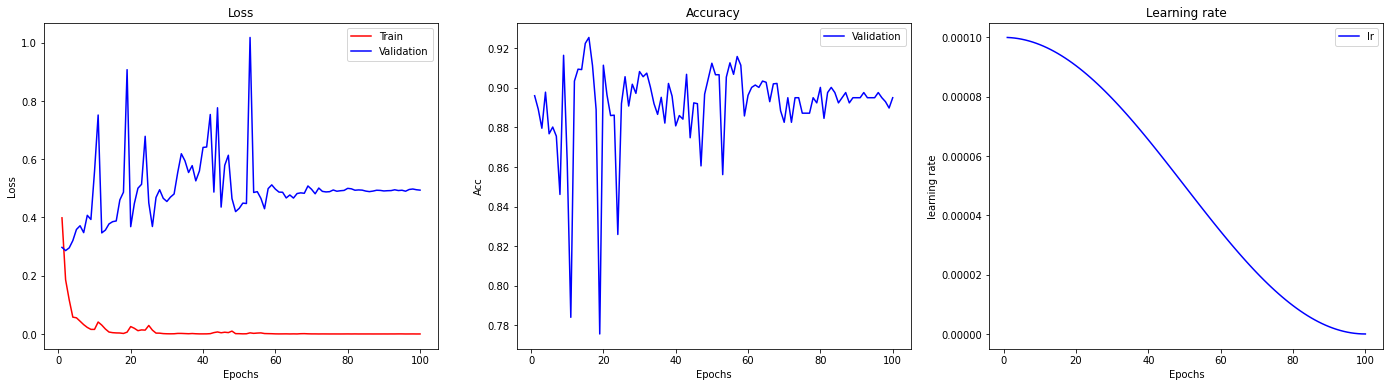

In [21]:
# plot training curves
epochs = range(1, len(history['train_loss']) + 1)

fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].plot(epochs, history['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, history['val_loss'], 'b-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history['val_acc'], 'b-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

ax[2].plot(epochs, history['lr'], 'b-', label='lr')
ax[2].set_title('Learning rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('learning rate')
ax[2].legend()

plt.show()

## ViT

### Pre-trained

In [26]:
# Load ResNet-50 model without the pre-trained weight
num_classes = 2
# hyperparamters
learning_rate = 1e-4
num_epochs = 100

model_name = 'vit_small_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)


out_name = f"{model_name}_pretrained"
history = train_model(model_name, model, train_loader, val_loader, out_name=out_name, device=device, lr=learning_rate, epochs=num_epochs)

metric_analysis(model, out_name=out_name, ckpt_path=f'./{out_name}_best_model.pt')

Training Start:


100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:1 / 100, lr: 0.000100 train loss:0.47008, val loss:0.30784, val acc:0.87540, max acc:0.87540


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:2 / 100, lr: 0.000100 train loss:0.24006, val loss:0.30245, val acc:0.90064, max acc:0.90064


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:3 / 100, lr: 0.000100 train loss:0.18505, val loss:0.29646, val acc:0.89103, max acc:0.90064


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch:4 / 100, lr: 0.000100 train loss:0.09920, val loss:0.41745, val acc:0.88321, max acc:0.90064


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:5 / 100, lr: 0.000099 train loss:0.07278, val loss:0.31507, val acc:0.88281, max acc:0.90064


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:6 / 100, lr: 0.000099 train loss:0.04533, val loss:0.47307, val acc:0.87981, max acc:0.90064


100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:7 / 100, lr: 0.000099 train loss:0.12317, val loss:0.45342, val acc:0.90325, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:8 / 100, lr: 0.000098 train loss:0.05154, val loss:0.39249, val acc:0.89904, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:9 / 100, lr: 0.000098 train loss:0.02501, val loss:0.45876, val acc:0.88221, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch:10 / 100, lr: 0.000098 train loss:0.02429, val loss:0.45916, val acc:0.88622, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:11 / 100, lr: 0.000097 train loss:0.01560, val loss:0.54592, val acc:0.87981, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:12 / 100, lr: 0.000096 train loss:0.01506, val loss:0.45506, val acc:0.89042, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:13 / 100, lr: 0.000096 train loss:0.05029, val loss:0.97018, val acc:0.76522, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:14 / 100, lr: 0.000095 train loss:0.03316, val loss:0.41438, val acc:0.89503, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch:15 / 100, lr: 0.000095 train loss:0.02768, val loss:0.49415, val acc:0.89183, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch:16 / 100, lr: 0.000094 train loss:0.00982, val loss:0.52865, val acc:0.86879, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch:17 / 100, lr: 0.000093 train loss:0.01745, val loss:0.51693, val acc:0.89984, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:18 / 100, lr: 0.000092 train loss:0.00510, val loss:0.50716, val acc:0.88421, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Epoch:19 / 100, lr: 0.000091 train loss:0.00218, val loss:0.55311, val acc:0.87881, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:20 / 100, lr: 0.000090 train loss:0.00162, val loss:0.59326, val acc:0.87680, max acc:0.90325


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:21 / 100, lr: 0.000090 train loss:0.00130, val loss:0.60190, val acc:0.90425, max acc:0.90425


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:22 / 100, lr: 0.000089 train loss:0.00107, val loss:0.56764, val acc:0.89383, max acc:0.90425


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:23 / 100, lr: 0.000088 train loss:0.00029, val loss:0.58248, val acc:0.90745, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:24 / 100, lr: 0.000086 train loss:0.00263, val loss:0.65317, val acc:0.88962, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:25 / 100, lr: 0.000085 train loss:0.00325, val loss:0.59529, val acc:0.88862, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch:26 / 100, lr: 0.000084 train loss:0.00441, val loss:0.56432, val acc:0.89062, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:27 / 100, lr: 0.000083 train loss:0.06083, val loss:0.49310, val acc:0.88261, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:28 / 100, lr: 0.000082 train loss:0.04198, val loss:0.38400, val acc:0.89363, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:29 / 100, lr: 0.000081 train loss:0.01441, val loss:0.48975, val acc:0.87179, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch:30 / 100, lr: 0.000079 train loss:0.01064, val loss:0.48654, val acc:0.87941, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:31 / 100, lr: 0.000078 train loss:0.01004, val loss:0.54082, val acc:0.88542, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:32 / 100, lr: 0.000077 train loss:0.00744, val loss:0.53741, val acc:0.88221, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:33 / 100, lr: 0.000075 train loss:0.00413, val loss:0.53686, val acc:0.88462, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:34 / 100, lr: 0.000074 train loss:0.00837, val loss:0.72358, val acc:0.86458, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:35 / 100, lr: 0.000073 train loss:0.02940, val loss:0.47532, val acc:0.89764, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:36 / 100, lr: 0.000071 train loss:0.00791, val loss:0.54424, val acc:0.87600, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:37 / 100, lr: 0.000070 train loss:0.00941, val loss:0.70644, val acc:0.84856, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Epoch:38 / 100, lr: 0.000068 train loss:0.00800, val loss:0.59274, val acc:0.89764, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:39 / 100, lr: 0.000067 train loss:0.00180, val loss:0.63717, val acc:0.90485, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:40 / 100, lr: 0.000065 train loss:0.00555, val loss:0.67806, val acc:0.88261, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:41 / 100, lr: 0.000064 train loss:0.00461, val loss:0.58145, val acc:0.89503, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:42 / 100, lr: 0.000062 train loss:0.00419, val loss:0.60107, val acc:0.88201, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:43 / 100, lr: 0.000061 train loss:0.00192, val loss:0.59637, val acc:0.89503, max acc:0.90745


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:44 / 100, lr: 0.000059 train loss:0.00034, val loss:0.61861, val acc:0.90805, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:45 / 100, lr: 0.000058 train loss:0.00040, val loss:0.61376, val acc:0.90685, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:46 / 100, lr: 0.000056 train loss:0.00010, val loss:0.59967, val acc:0.90164, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch:47 / 100, lr: 0.000055 train loss:0.00009, val loss:0.59975, val acc:0.90485, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:48 / 100, lr: 0.000053 train loss:0.00011, val loss:0.60652, val acc:0.89503, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:49 / 100, lr: 0.000052 train loss:0.00030, val loss:0.61971, val acc:0.89904, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:50 / 100, lr: 0.000050 train loss:0.00050, val loss:0.63623, val acc:0.89443, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Epoch:51 / 100, lr: 0.000048 train loss:0.00010, val loss:0.63996, val acc:0.89303, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.41it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:52 / 100, lr: 0.000047 train loss:0.00012, val loss:0.64685, val acc:0.90545, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Epoch:53 / 100, lr: 0.000045 train loss:0.00016, val loss:0.64014, val acc:0.90084, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:54 / 100, lr: 0.000044 train loss:0.00006, val loss:0.64269, val acc:0.90485, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:55 / 100, lr: 0.000042 train loss:0.00004, val loss:0.64366, val acc:0.89964, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:56 / 100, lr: 0.000041 train loss:0.00004, val loss:0.64357, val acc:0.90345, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:57 / 100, lr: 0.000039 train loss:0.00004, val loss:0.64651, val acc:0.90224, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:58 / 100, lr: 0.000038 train loss:0.00004, val loss:0.64742, val acc:0.90545, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:59 / 100, lr: 0.000036 train loss:0.00006, val loss:0.65550, val acc:0.90485, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:60 / 100, lr: 0.000035 train loss:0.00004, val loss:0.65482, val acc:0.90485, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:61 / 100, lr: 0.000033 train loss:0.00004, val loss:0.65519, val acc:0.89964, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:62 / 100, lr: 0.000032 train loss:0.00003, val loss:0.65500, val acc:0.89704, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:63 / 100, lr: 0.000030 train loss:0.00002, val loss:0.65528, val acc:0.90284, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:64 / 100, lr: 0.000029 train loss:0.00003, val loss:0.65550, val acc:0.90605, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:65 / 100, lr: 0.000027 train loss:0.00003, val loss:0.65598, val acc:0.90605, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch:66 / 100, lr: 0.000026 train loss:0.00003, val loss:0.65680, val acc:0.90605, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Epoch:67 / 100, lr: 0.000025 train loss:0.00003, val loss:0.65810, val acc:0.90605, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch:68 / 100, lr: 0.000023 train loss:0.00002, val loss:0.65876, val acc:0.90605, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:69 / 100, lr: 0.000022 train loss:0.00004, val loss:0.66082, val acc:0.90545, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:70 / 100, lr: 0.000021 train loss:0.00002, val loss:0.66177, val acc:0.90545, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch:71 / 100, lr: 0.000019 train loss:0.00002, val loss:0.66223, val acc:0.90545, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:72 / 100, lr: 0.000018 train loss:0.00005, val loss:0.66275, val acc:0.90805, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:73 / 100, lr: 0.000017 train loss:0.00003, val loss:0.66640, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch:74 / 100, lr: 0.000016 train loss:0.00004, val loss:0.66761, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch:75 / 100, lr: 0.000015 train loss:0.00003, val loss:0.66757, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Epoch:76 / 100, lr: 0.000014 train loss:0.00002, val loss:0.66812, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.18it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:77 / 100, lr: 0.000012 train loss:0.00002, val loss:0.66835, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:78 / 100, lr: 0.000011 train loss:0.00002, val loss:0.66840, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch:79 / 100, lr: 0.000010 train loss:0.00003, val loss:0.66950, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch:80 / 100, lr: 0.000010 train loss:0.00002, val loss:0.66990, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:81 / 100, lr: 0.000009 train loss:0.00002, val loss:0.66992, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:82 / 100, lr: 0.000008 train loss:0.00002, val loss:0.66997, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:83 / 100, lr: 0.000007 train loss:0.00002, val loss:0.66983, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch:84 / 100, lr: 0.000006 train loss:0.00002, val loss:0.66998, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:85 / 100, lr: 0.000005 train loss:0.00002, val loss:0.67011, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch:86 / 100, lr: 0.000005 train loss:0.00002, val loss:0.67029, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:87 / 100, lr: 0.000004 train loss:0.00002, val loss:0.67042, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch:88 / 100, lr: 0.000004 train loss:0.00002, val loss:0.67052, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:89 / 100, lr: 0.000003 train loss:0.00002, val loss:0.67049, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:90 / 100, lr: 0.000002 train loss:0.00002, val loss:0.67053, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch:91 / 100, lr: 0.000002 train loss:0.00002, val loss:0.67049, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:92 / 100, lr: 0.000002 train loss:0.00002, val loss:0.67034, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:93 / 100, lr: 0.000001 train loss:0.00002, val loss:0.67039, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Epoch:94 / 100, lr: 0.000001 train loss:0.00002, val loss:0.67037, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:95 / 100, lr: 0.000001 train loss:0.00002, val loss:0.67038, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.39it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:96 / 100, lr: 0.000000 train loss:0.00002, val loss:0.67039, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epoch:97 / 100, lr: 0.000000 train loss:0.00002, val loss:0.67038, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:98 / 100, lr: 0.000000 train loss:0.00002, val loss:0.67036, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:99 / 100, lr: 0.000000 train loss:0.00002, val loss:0.67033, val acc:0.90745, max acc:0.90805


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Epoch:100 / 100, lr: 0.000000 train loss:0.00002, val loss:0.67036, val acc:0.90745, max acc:0.90805
best_epoch:43, best accuracy:0.9080528846153846
Test starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Test Accuracy:  0.9080528846153846
AUROC: 0.9274
TN:265, FP:13, FN:20, TP:74
acc.:0.9113
Sensitivity: 0.7872
Specificity: 0.9532
Positive predictive value: 0.8506
Negative predictive value: 0.9298
F1-score: 0.8177
{'auc': 0.9273878931999207, 'Sensitivity': 0.7872340679168701, 'Specificity': 0.9532374143600464, 'Positive predictive value': 0.8505747318267822, 'Negative predictive value': 0.9298245906829834, 'f1_score': 0.8176795244216919, 'Accuracy': 0.9080528846153846}



/home/lsrock1/anaconda3/envs/pytorch1.9/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### from-scratch

In [27]:
# Load ResNet-50 model without the pre-trained weight
num_classes = 2
# hyperparamters
learning_rate = 1e-4
num_epochs = 100

model_name = 'vit_small_patch16_224'
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)


out_name = f"{model_name}_from_scratch"
history = train_model(model_name, model, train_loader, val_loader, out_name=out_name, device=device, lr=learning_rate, epochs=num_epochs)

metric_analysis(model, out_name=out_name, ckpt_path=f'./{out_name}_best_model.pt')

Training Start:


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:1 / 100, lr: 0.000100 train loss:0.79289, val loss:0.62751, val acc:0.68530, max acc:0.68530


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:2 / 100, lr: 0.000100 train loss:0.67690, val loss:0.60366, val acc:0.71454, max acc:0.71454


100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch:3 / 100, lr: 0.000100 train loss:0.66788, val loss:0.60206, val acc:0.74379, max acc:0.74379


100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:4 / 100, lr: 0.000100 train loss:0.68580, val loss:0.63593, val acc:0.64764, max acc:0.74379


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:5 / 100, lr: 0.000099 train loss:0.65057, val loss:0.57504, val acc:0.71675, max acc:0.74379


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:6 / 100, lr: 0.000099 train loss:0.62641, val loss:0.51045, val acc:0.79948, max acc:0.79948


100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:7 / 100, lr: 0.000099 train loss:0.60957, val loss:0.42931, val acc:0.80509, max acc:0.80509


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:8 / 100, lr: 0.000098 train loss:0.58036, val loss:0.50177, val acc:0.76963, max acc:0.80509


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:9 / 100, lr: 0.000098 train loss:0.53126, val loss:0.40359, val acc:0.82993, max acc:0.82993


100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:10 / 100, lr: 0.000098 train loss:0.50752, val loss:0.40598, val acc:0.82552, max acc:0.82993


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch:11 / 100, lr: 0.000097 train loss:0.47626, val loss:0.44618, val acc:0.80649, max acc:0.82993


100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:12 / 100, lr: 0.000096 train loss:0.50511, val loss:0.39960, val acc:0.84235, max acc:0.84235


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:13 / 100, lr: 0.000096 train loss:0.46894, val loss:0.38556, val acc:0.83954, max acc:0.84235


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Epoch:14 / 100, lr: 0.000095 train loss:0.46117, val loss:0.40757, val acc:0.83694, max acc:0.84235


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:15 / 100, lr: 0.000095 train loss:0.43640, val loss:0.36526, val acc:0.86318, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Epoch:16 / 100, lr: 0.000094 train loss:0.42906, val loss:0.45086, val acc:0.80409, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:17 / 100, lr: 0.000093 train loss:0.44622, val loss:0.38675, val acc:0.84435, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch:18 / 100, lr: 0.000092 train loss:0.44614, val loss:0.46594, val acc:0.78325, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:19 / 100, lr: 0.000091 train loss:0.42387, val loss:0.37386, val acc:0.83734, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch:20 / 100, lr: 0.000090 train loss:0.38768, val loss:0.43163, val acc:0.81510, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:21 / 100, lr: 0.000090 train loss:0.37016, val loss:0.37163, val acc:0.85958, max acc:0.86318


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:22 / 100, lr: 0.000089 train loss:0.37701, val loss:0.36846, val acc:0.87460, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:23 / 100, lr: 0.000088 train loss:0.36156, val loss:0.35561, val acc:0.85457, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:24 / 100, lr: 0.000086 train loss:0.34827, val loss:0.42056, val acc:0.84736, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:25 / 100, lr: 0.000085 train loss:0.36073, val loss:0.38211, val acc:0.86378, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:26 / 100, lr: 0.000084 train loss:0.39275, val loss:0.44438, val acc:0.80869, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:27 / 100, lr: 0.000083 train loss:0.36751, val loss:0.44007, val acc:0.78846, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:28 / 100, lr: 0.000082 train loss:0.34914, val loss:0.44886, val acc:0.78005, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:29 / 100, lr: 0.000081 train loss:0.34164, val loss:0.36663, val acc:0.85817, max acc:0.87460


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:30 / 100, lr: 0.000079 train loss:0.33514, val loss:0.34851, val acc:0.88061, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:31 / 100, lr: 0.000078 train loss:0.34356, val loss:0.36936, val acc:0.86799, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch:32 / 100, lr: 0.000077 train loss:0.31743, val loss:0.47699, val acc:0.77604, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:33 / 100, lr: 0.000075 train loss:0.32463, val loss:0.44240, val acc:0.80929, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch:34 / 100, lr: 0.000074 train loss:0.31906, val loss:0.51298, val acc:0.76883, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:35 / 100, lr: 0.000073 train loss:0.31809, val loss:0.36162, val acc:0.86619, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:36 / 100, lr: 0.000071 train loss:0.31605, val loss:0.38507, val acc:0.87520, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch:37 / 100, lr: 0.000070 train loss:0.30807, val loss:0.43635, val acc:0.81390, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:38 / 100, lr: 0.000068 train loss:0.28714, val loss:0.40004, val acc:0.83674, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:39 / 100, lr: 0.000067 train loss:0.30945, val loss:0.40975, val acc:0.82432, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:40 / 100, lr: 0.000065 train loss:0.32569, val loss:0.43104, val acc:0.82292, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:41 / 100, lr: 0.000064 train loss:0.32487, val loss:0.38105, val acc:0.86118, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:42 / 100, lr: 0.000062 train loss:0.30612, val loss:0.37959, val acc:0.85296, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:43 / 100, lr: 0.000061 train loss:0.28388, val loss:0.39183, val acc:0.85196, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:44 / 100, lr: 0.000059 train loss:0.27784, val loss:0.36818, val acc:0.86298, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:45 / 100, lr: 0.000058 train loss:0.27429, val loss:0.44716, val acc:0.85317, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:46 / 100, lr: 0.000056 train loss:0.28397, val loss:0.39351, val acc:0.87720, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:47 / 100, lr: 0.000055 train loss:0.28159, val loss:0.41866, val acc:0.82492, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:48 / 100, lr: 0.000053 train loss:0.25449, val loss:0.45524, val acc:0.85357, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:49 / 100, lr: 0.000052 train loss:0.25365, val loss:0.49054, val acc:0.76562, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:50 / 100, lr: 0.000050 train loss:0.25882, val loss:0.43265, val acc:0.83213, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch:51 / 100, lr: 0.000048 train loss:0.24114, val loss:0.42521, val acc:0.84335, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:52 / 100, lr: 0.000047 train loss:0.24383, val loss:0.41035, val acc:0.86338, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:53 / 100, lr: 0.000045 train loss:0.25384, val loss:0.46118, val acc:0.81971, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:54 / 100, lr: 0.000044 train loss:0.25831, val loss:0.48058, val acc:0.79688, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:55 / 100, lr: 0.000042 train loss:0.24081, val loss:0.44456, val acc:0.86098, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch:56 / 100, lr: 0.000041 train loss:0.24722, val loss:0.50969, val acc:0.77804, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Epoch:57 / 100, lr: 0.000039 train loss:0.23886, val loss:0.43327, val acc:0.84315, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch:58 / 100, lr: 0.000038 train loss:0.21576, val loss:0.48346, val acc:0.80529, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:59 / 100, lr: 0.000036 train loss:0.24065, val loss:0.41836, val acc:0.85136, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:60 / 100, lr: 0.000035 train loss:0.22624, val loss:0.52527, val acc:0.75901, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:61 / 100, lr: 0.000033 train loss:0.21768, val loss:0.67359, val acc:0.68530, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:62 / 100, lr: 0.000032 train loss:0.20753, val loss:0.52201, val acc:0.78446, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:63 / 100, lr: 0.000030 train loss:0.19946, val loss:0.49889, val acc:0.82031, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:64 / 100, lr: 0.000029 train loss:0.19614, val loss:0.50894, val acc:0.81831, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:65 / 100, lr: 0.000027 train loss:0.18925, val loss:0.53297, val acc:0.76763, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:66 / 100, lr: 0.000026 train loss:0.19729, val loss:0.50193, val acc:0.81771, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:67 / 100, lr: 0.000025 train loss:0.17490, val loss:0.53309, val acc:0.81510, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:68 / 100, lr: 0.000023 train loss:0.18512, val loss:0.58276, val acc:0.77464, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.19it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:69 / 100, lr: 0.000022 train loss:0.16367, val loss:0.68399, val acc:0.70553, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.17it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:70 / 100, lr: 0.000021 train loss:0.18399, val loss:0.49699, val acc:0.82372, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:71 / 100, lr: 0.000019 train loss:0.18647, val loss:0.56688, val acc:0.77845, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:72 / 100, lr: 0.000018 train loss:0.17071, val loss:0.60231, val acc:0.76222, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch:73 / 100, lr: 0.000017 train loss:0.16121, val loss:0.61817, val acc:0.77083, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:74 / 100, lr: 0.000016 train loss:0.15017, val loss:0.72696, val acc:0.74659, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch:75 / 100, lr: 0.000015 train loss:0.16686, val loss:0.62469, val acc:0.77143, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch:76 / 100, lr: 0.000014 train loss:0.16117, val loss:0.58302, val acc:0.79828, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:77 / 100, lr: 0.000012 train loss:0.13900, val loss:0.64835, val acc:0.77784, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:78 / 100, lr: 0.000011 train loss:0.14531, val loss:0.66863, val acc:0.77664, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:79 / 100, lr: 0.000010 train loss:0.14261, val loss:0.61154, val acc:0.78966, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:80 / 100, lr: 0.000010 train loss:0.13816, val loss:0.61390, val acc:0.81330, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:81 / 100, lr: 0.000009 train loss:0.15230, val loss:0.62383, val acc:0.77925, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch:82 / 100, lr: 0.000008 train loss:0.12537, val loss:0.76785, val acc:0.73818, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:83 / 100, lr: 0.000007 train loss:0.11550, val loss:0.71212, val acc:0.77344, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:84 / 100, lr: 0.000006 train loss:0.14232, val loss:0.68927, val acc:0.75441, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch:85 / 100, lr: 0.000005 train loss:0.12754, val loss:0.75069, val acc:0.75381, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Epoch:86 / 100, lr: 0.000005 train loss:0.12500, val loss:0.78079, val acc:0.73357, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.08it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:87 / 100, lr: 0.000004 train loss:0.12068, val loss:0.87033, val acc:0.71214, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch:88 / 100, lr: 0.000004 train loss:0.10667, val loss:0.77357, val acc:0.76362, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch:89 / 100, lr: 0.000003 train loss:0.11366, val loss:0.83435, val acc:0.73618, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:90 / 100, lr: 0.000002 train loss:0.11964, val loss:0.79177, val acc:0.74399, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:91 / 100, lr: 0.000002 train loss:0.10563, val loss:0.76240, val acc:0.76102, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch:92 / 100, lr: 0.000002 train loss:0.11414, val loss:0.82682, val acc:0.72977, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch:93 / 100, lr: 0.000001 train loss:0.09920, val loss:0.77543, val acc:0.75260, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.06it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Epoch:94 / 100, lr: 0.000001 train loss:0.10668, val loss:0.83649, val acc:0.73237, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch:95 / 100, lr: 0.000001 train loss:0.10639, val loss:0.81559, val acc:0.73438, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch:96 / 100, lr: 0.000000 train loss:0.10929, val loss:0.79419, val acc:0.73958, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch:97 / 100, lr: 0.000000 train loss:0.09994, val loss:0.79915, val acc:0.74279, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch:98 / 100, lr: 0.000000 train loss:0.10356, val loss:0.80973, val acc:0.73758, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Epoch:99 / 100, lr: 0.000000 train loss:0.11179, val loss:0.80393, val acc:0.74279, max acc:0.88061


100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


validation starts!


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch:100 / 100, lr: 0.000000 train loss:0.10968, val loss:0.80308, val acc:0.74279, max acc:0.88061
best_epoch:29, best accuracy:0.8806089743589743
Test starts!


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Test Accuracy:  0.8806089743589743
AUROC: 0.8812
TN:271, FP:7, FN:34, TP:60
acc.:0.8898
Sensitivity: 0.6383
Specificity: 0.9748
Positive predictive value: 0.8955
Negative predictive value: 0.8885
F1-score: 0.7453
{'auc': 0.8811610341072083, 'Sensitivity': 0.6382978558540344, 'Specificity': 0.9748201370239258, 'Positive predictive value': 0.89552241563797, 'Negative predictive value': 0.88852459192276, 'f1_score': 0.7453415989875793, 'Accuracy': 0.8806089743589743}


## Test on external data

In [28]:
def metric_analysis_ext(model, out_name, ckpt_path, test_loader):
    
    ckpt = torch.load(ckpt_path)
    msg = model.load_state_dict(ckpt)
    print(msg)
    
    test_acc = 0.
    y_pred_list = []
    y_target_list = []
    logs = {}

    model.eval()  # start to train the model, activate training behavior
    with torch.no_grad():  # tell pytorch not to update parameters
        print("Test starts!")
        for data in tqdm.tqdm(test_loader):

            inputs, labels = data[0].to(device), data[1].to(device)            
            outputs = model(inputs)

            _, preds = torch.max(outputs.data, dim=1) 
            cur_val = (preds == labels).sum().item() / labels.size(0)
            test_acc += cur_val
            
            y_pred_list.append(outputs)
            y_target_list.append(labels)
            
            final_acc = (test_acc / len(test_loader))

    print(f'\nTest Accuracy:  {final_acc}')

    y_pred_list = torch.cat(y_pred_list)
    y_target_list = torch.cat(y_target_list)

    auroc = AUROC(num_classes=2).to(device)
    cfmat = ConfusionMatrix(num_classes=2).to(device)

    auc_all = auroc(y_pred_list, y_target_list)
    print(f'AUROC: {auc_all:.4f}')
    logs['auc'] = auc_all.item()

    cfmat_all = cfmat(y_pred_list, y_target_list)
    TN, FP, FN, TP = cfmat_all[0][0], cfmat_all[0][1], cfmat_all[1][0], cfmat_all[1][1]

    print(f'TN:{cfmat_all[0][0]}, FP:{cfmat_all[0][1]}, FN:{cfmat_all[1][0]}, TP:{cfmat_all[1][1]}')

    accuracy = (TP + TN) / (TP+TN+FP+FN)
    print(f'acc.:{accuracy:.4f}')

    # Sensitivity -> TPR = TP / (TP + FN)
    TPR = TP/(TP + FN)
    print(f'Sensitivity: {TPR:.4f}')
    logs['Sensitivity'] = TPR.item()
    # Specificity -> TNR = TN / (TN + FP)
    TNR = TN/(TN + FP)
    print(f'Specificity: {TNR:.4f}')
    logs['Specificity'] = TNR.item()
    # Positive predictive value -> TP / (TP + FP) = Precision (PPV)
    PPV = TP/(TP + FP)
    print(f'Positive predictive value: {PPV:.4f}')
    logs['Positive predictive value'] = PPV.item()
    # negative predictive value -> TN / (TN + FN)
    NPV = TN/(TN + FN)
    print(f'Negative predictive value: {NPV:.4f}')
    logs['Negative predictive value'] = NPV.item()
    # F1-Score -> 2 x (PPV x TPR) / (PPV + TPR)
    f1_score = 2 * (PPV * TPR) / (PPV + TPR)
    print(f'F1-score: {f1_score:.4f}')
    logs['f1_score'] = f1_score.item()

    logs['Accuracy'] = final_acc

    import json
    with open(f"./{out_name}_metrics.txt", "w") as fp:
        json.dump(logs, fp)
    
    print(logs)


#### Int_val

In [146]:
TEST = "Int_val"
test_set = ImageFolder(os.path.join(data_dir, TEST), transform=data_transforms(TEST)) # 3-channel input tensor
test_set
# print(test_set.classes)



Dataset ImageFolder
    Number of datapoints: 300
    Root location: /home/lsrock1/data/polyp/Int_val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [147]:
test_loader = DataLoader(test_set, batch_size, shuffle=False, drop_last=False, num_workers=8)

In [148]:
model_name = 'inception_v3'

# from-scratch
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_from_scratch_best_model.pt"
out_name = f"{model_name}_from_scratch_int_val"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=val_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

<All keys matched successfully>
Test starts!


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


Test Accuracy:  0.8255208333333334
AUROC: 0.8092
TN:256, FP:22, FN:39, TP:55
acc.:0.8360
Sensitivity: 0.5851
Specificity: 0.9209
Positive predictive value: 0.7143
Negative predictive value: 0.8678
F1-score: 0.6433
{'auc': 0.8091803789138794, 'Sensitivity': 0.585106372833252, 'Specificity': 0.9208633303642273, 'Positive predictive value': 0.7142857313156128, 'Negative predictive value': 0.8677965998649597, 'f1_score': 0.6432748436927795, 'Accuracy': 0.8255208333333334}


### Asan

In [29]:
TEST = "Ext_val/as"
test_set = ImageFolder(os.path.join(data_dir, TEST), transform=data_transforms(TEST)) # 3-channel input tensor
test_set
# print(test_set.classes)

test_loader = DataLoader(test_set, batch_size, shuffle=False, drop_last=False, num_workers=8)



#### Inception

In [30]:
model_name = 'inception_v3'

# from-scratch
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_from_scratch_best_model.pt"
out_name = f"{model_name}_from_scratch_ext_as"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

FileNotFoundError: [Errno 2] No such file or directory: 'inception_v3_from_scratch_best_model.pt'

In [142]:
# pretrained
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_pretrained_best_model.pt"
out_name = f"{model_name}_pretrained_ext_as"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

<All keys matched successfully>
Test starts!


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Test Accuracy:  0.8991477272727273
AUROC: 0.9654
TN:166, FP:14, FN:16, TP:104
acc.:0.9000
Sensitivity: 0.8667
Specificity: 0.9222
Positive predictive value: 0.8814
Negative predictive value: 0.9121
F1-score: 0.8739
{'auc': 0.965416669845581, 'Sensitivity': 0.8666666746139526, 'Specificity': 0.9222221970558167, 'Positive predictive value': 0.8813559412956238, 'Negative predictive value': 0.9120879173278809, 'f1_score': 0.8739495873451233, 'Accuracy': 0.8991477272727273}


#### ViT

In [33]:
model_name = 'vit_small_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_pretrained_best_model.pt"
out_name = f"{model_name}_pretrained_ext_as"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Test Accuracy:  0.7083333333333334
AUROC: 0.7713
TN:88, FP:17, FN:18, TP:21
acc.:0.7569
Sensitivity: 0.5385
Specificity: 0.8381
Positive predictive value: 0.5526
Negative predictive value: 0.8302
F1-score: 0.5455
{'auc': 0.7713065147399902, 'Sensitivity': 0.5384615659713745, 'Specificity': 0.8380952477455139, 'Positive predictive value': 0.5526315569877625, 'Negative predictive value': 0.8301886916160583, 'f1_score': 0.5454545617103577, 'Accuracy': 0.7083333333333334}


#### mpvit

In [43]:
drop_rate = 0.3
# model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)
model = mpvit_small(num_classes=2, drop_path_rate=drop_path_rate, drop_rate=drop_rate)
model = model.to(device)
model_name = 'mpvit_small_0.0_dropout_0.3_pretrained'
ckpt_path = f"{model_name}_best_model.pt"
out_name = f"{model_name}_ext_as"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Test Accuracy:  0.8457386363636363
AUROC: 0.8551
TN:235, FP:7, FN:31, TP:27
acc.:0.8733
Sensitivity: 0.4655
Specificity: 0.9711
Positive predictive value: 0.7941
Negative predictive value: 0.8835
F1-score: 0.5870
{'auc': 0.8551225662231445, 'Sensitivity': 0.4655172526836395, 'Specificity': 0.9710744023323059, 'Positive predictive value': 0.7941176295280457, 'Negative predictive value': 0.88345867395401, 'f1_score': 0.5869565606117249, 'Accuracy': 0.8457386363636363}


### YS

In [34]:
TEST = "Ext_val/ys"
test_set = ImageFolder(os.path.join(data_dir, TEST), transform=data_transforms(TEST)) # 3-channel input tensor
test_set
print(test_set.classes)

test_loader = DataLoader(test_set, batch_size, shuffle=False, drop_last=False, num_workers=8)

['AD', 'HP']


In [113]:
model_name = 'inception_v3'

# from-scratch
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_from_scratch_best_model.pt"
out_name = f"{model_name}_from_scratch_ext_ys"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

Test starts!


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Test Accuracy:  0.359375
AUROC: 0.3775
TN:25, FP:14, FN:79, TP:26
acc.:0.3542
Sensitivity: 0.2476
Specificity: 0.6410
Positive predictive value: 0.6500
Negative predictive value: 0.2404
F1-score: 0.3586
{'auc': 0.37753355503082275, 'Sensitivity': 0.24761904776096344, 'Specificity': 0.6410256624221802, 'Positive predictive value': 0.6499999761581421, 'Negative predictive value': 0.24038460850715637, 'f1_score': 0.35862070322036743, 'Accuracy': 0.359375}


In [114]:
# pretrained
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_pretrained_best_model.pt"
out_name = f"{model_name}_pretrained_ext_ys"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

Test starts!


100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Test Accuracy:  0.265625
AUROC: 0.2752
TN:19, FP:20, FN:79, TP:26
acc.:0.3125
Sensitivity: 0.2476
Specificity: 0.4872
Positive predictive value: 0.5652
Negative predictive value: 0.1939
F1-score: 0.3444
{'auc': 0.27521365880966187, 'Sensitivity': 0.24761904776096344, 'Specificity': 0.4871794879436493, 'Positive predictive value': 0.5652173757553101, 'Negative predictive value': 0.19387754797935486, 'f1_score': 0.34437087178230286, 'Accuracy': 0.265625}


In [35]:
model_name = 'vit_small_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_pretrained_best_model.pt"
out_name = f"{model_name}_pretrained_ext_ys"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Test Accuracy:  0.7083333333333334
AUROC: 0.7713
TN:88, FP:17, FN:18, TP:21
acc.:0.7569
Sensitivity: 0.5385
Specificity: 0.8381
Positive predictive value: 0.5526
Negative predictive value: 0.8302
F1-score: 0.5455
{'auc': 0.7713065147399902, 'Sensitivity': 0.5384615659713745, 'Specificity': 0.8380952477455139, 'Positive predictive value': 0.5526315569877625, 'Negative predictive value': 0.8301886916160583, 'f1_score': 0.5454545617103577, 'Accuracy': 0.7083333333333334}


In [30]:
drop_rate = 0.3
# model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)
model = mpvit_small(num_classes=2, drop_path_rate=drop_path_rate, drop_rate=drop_rate)
model = model.to(device)
model_name = 'mpvit_small_0.0_dropout_0.3_pretrained'
ckpt_path = f"{model_name}_best_model.pt"
out_name = f"{model_name}_pretrained_ext_ys"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]



Test Accuracy:  0.671875
AUROC: 0.7405
TN:81, FP:24, FN:15, TP:24
acc.:0.7292
Sensitivity: 0.6154
Specificity: 0.7714
Positive predictive value: 0.5000
Negative predictive value: 0.8438
F1-score: 0.5517
{'auc': 0.7405372262001038, 'Sensitivity': 0.6153846383094788, 'Specificity': 0.7714285850524902, 'Positive predictive value': 0.5, 'Negative predictive value': 0.84375, 'f1_score': 0.5517241954803467, 'Accuracy': 0.671875}


### EW

In [37]:
TEST = "Ext_val/ew"
test_set = ImageFolder(os.path.join(data_dir, TEST), transform=data_transforms(TEST)) # 3-channel input tensor
test_set
print(test_set.classes)

test_loader = DataLoader(test_set, batch_size, shuffle=False, drop_last=False,  num_workers=8)

['AD', 'HP']


In [118]:
model_name = 'inception_v3'

# from-scratch
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_from_scratch_best_model.pt"
out_name = f"{model_name}_from_scratch_ext_ew"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

Test starts!


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Test Accuracy:  0.31960227272727276
AUROC: 0.3042
TN:26, FP:47, FN:137, TP:57
acc.:0.3109
Sensitivity: 0.2938
Specificity: 0.3562
Positive predictive value: 0.5481
Negative predictive value: 0.1595
F1-score: 0.3826
{'auc': 0.3041943311691284, 'Sensitivity': 0.29381442070007324, 'Specificity': 0.3561643958091736, 'Positive predictive value': 0.5480769276618958, 'Negative predictive value': 0.15950919687747955, 'f1_score': 0.38255032896995544, 'Accuracy': 0.31960227272727276}


In [119]:
# pretrained
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_pretrained_best_model.pt"
out_name = f"{model_name}_pretrained_ext_ew"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

Test starts!


100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


Test Accuracy:  0.26647727272727273
AUROC: 0.1992
TN:23, FP:50, FN:151, TP:43
acc.:0.2472
Sensitivity: 0.2216
Specificity: 0.3151
Positive predictive value: 0.4624
Negative predictive value: 0.1322
F1-score: 0.2997
{'auc': 0.19915972650051117, 'Sensitivity': 0.22164948284626007, 'Specificity': 0.31506848335266113, 'Positive predictive value': 0.46236559748649597, 'Negative predictive value': 0.13218390941619873, 'f1_score': 0.299651563167572, 'Accuracy': 0.26647727272727273}


In [38]:
model_name = 'vit_small_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

ckpt_path = f"{model_name}_pretrained_best_model.pt"
out_name = f"{model_name}_pretrained_ext_ew"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Test Accuracy:  0.8017045454545455
AUROC: 0.8416
TN:172, FP:22, FN:27, TP:46
acc.:0.8165
Sensitivity: 0.6301
Specificity: 0.8866
Positive predictive value: 0.6765
Negative predictive value: 0.8643
F1-score: 0.6525
{'auc': 0.8416184186935425, 'Sensitivity': 0.6301369667053223, 'Specificity': 0.8865979313850403, 'Positive predictive value': 0.6764705777168274, 'Negative predictive value': 0.8643215894699097, 'f1_score': 0.652482271194458, 'Accuracy': 0.8017045454545455}


In [33]:
drop_rate = 0.3
# model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)
model = mpvit_small(num_classes=2, drop_path_rate=drop_path_rate, drop_rate=drop_rate)
model = model.to(device)
model_name = 'mpvit_small_0.0_dropout_0.3_pretrained'
ckpt_path = f"{model_name}_best_model.pt"
out_name = f"{model_name}_pretrained_ext_ew"
metric_analysis_ext(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=test_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]



Test Accuracy:  0.7693181818181818
AUROC: 0.8257
TN:144, FP:50, FN:19, TP:54
acc.:0.7416
Sensitivity: 0.7397
Specificity: 0.7423
Positive predictive value: 0.5192
Negative predictive value: 0.8834
F1-score: 0.6102
{'auc': 0.8256955146789551, 'Sensitivity': 0.7397260069847107, 'Specificity': 0.7422680258750916, 'Positive predictive value': 0.5192307829856873, 'Negative predictive value': 0.8834356069564819, 'f1_score': 0.6101694703102112, 'Accuracy': 0.7693181818181818}


## Measure inference time

In [15]:
batch_size = 1

val_loader = DataLoader(val_set, batch_size, shuffle=False, drop_last=False, num_workers=8)

In [16]:
import time

In [32]:
def metric_analysis_ext_multi_time(model, out_name, ckpt_path, test_loader, repeat=100, method='parallel'):
    assert method in ['parallel', 'repeat']
    ckpt = torch.load(ckpt_path)
    msg = model.load_state_dict(ckpt)
    print(msg)
    
    test_acc = 0.
    y_pred_list = []
    y_target_list = []
    logs = {}

    model.eval()  # start to train the model, activate training behavior
    total_time = 0.
    first_sample = True
    with torch.no_grad():  # tell pytorch not to update parameters
        print("Test starts!")
        for data in tqdm.tqdm(test_loader):

            inputs, labels = data[0].to(device), data[1].to(device) # batch size = 1
            
            torch.cuda.synchronize()  # Synchronize before starting the timer
            start_time = time.time()

            if method == 'parallel':
                p_outputs = []
                for input_ in inputs:
                    input_ = input_.unsqueeze(0).repeat(repeat, 1, 1, 1)
                    outputs = model(input_).mean(dim=0).unsqueeze(0)
                    p_outputs.append(outputs)
                outputs = torch.cat(p_outputs)
            else:
                outputs = 0
                for _ in range(repeat):
                    outputs += model(inputs)
                outputs = outputs / repeat

            if first_sample:
                first_sample = False
                continue
            torch.cuda.synchronize()  # Synchronize after finishing the computation
            total_time += time.time() - start_time


            y_pred_list.append(outputs)
            y_target_list.append(labels)
            # outputs = model(inputs)

            _, preds = torch.max(outputs.data, dim=1) 
            cur_val = (preds == labels).sum().item() / labels.size(0)
            test_acc += cur_val
            
            y_pred_list.append(outputs)
            y_target_list.append(labels)
            
            final_acc = (test_acc / len(test_loader))

    average_time = total_time / (len(test_loader) - 1 )
    print(f'average inference time: {average_time} s')

    print(f'\nTest Accuracy:  {final_acc}')

    y_pred_list = torch.cat(y_pred_list)
    y_target_list = torch.cat(y_target_list)

    auroc = AUROC(num_classes=2).to(device)
    cfmat = ConfusionMatrix(num_classes=2).to(device)

    auc_all = auroc(y_pred_list, y_target_list)
    print(f'AUROC: {auc_all:.4f}')
    logs['auc'] = auc_all.item()

    cfmat_all = cfmat(y_pred_list, y_target_list)
    TN, FP, FN, TP = cfmat_all[0][0], cfmat_all[0][1], cfmat_all[1][0], cfmat_all[1][1]

    print(f'TN:{cfmat_all[0][0]}, FP:{cfmat_all[0][1]}, FN:{cfmat_all[1][0]}, TP:{cfmat_all[1][1]}')

    accuracy = (TP + TN) / (TP+TN+FP+FN)
    print(f'acc.:{accuracy:.4f}')

    # Sensitivity -> TPR = TP / (TP + FN)
    TPR = TP/(TP + FN)
    print(f'Sensitivity: {TPR:.4f}')
    logs['Sensitivity'] = TPR.item()
    # Specificity -> TNR = TN / (TN + FP)
    TNR = TN/(TN + FP)
    print(f'Specificity: {TNR:.4f}')
    logs['Specificity'] = TNR.item()
    # Positive predictive value -> TP / (TP + FP) = Precision (PPV)
    PPV = TP/(TP + FP)
    print(f'Positive predictive value: {PPV:.4f}')
    logs['Positive predictive value'] = PPV.item()
    # negative predictive value -> TN / (TN + FN)
    NPV = TN/(TN + FN)
    print(f'Negative predictive value: {NPV:.4f}')
    logs['Negative predictive value'] = NPV.item()
    # F1-Score -> 2 x (PPV x TPR) / (PPV + TPR)
    f1_score = 2 * (PPV * TPR) / (PPV + TPR)
    print(f'F1-score: {f1_score:.4f}')
    logs['f1_score'] = f1_score.item()

    logs['Accuracy'] = final_acc

    import json
    with open(f"./{out_name}_metrics.txt", "w") as fp:
        json.dump(logs, fp)
    
    print(logs)


In [33]:
drop_rate = 0.3
# model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)
model = mpvit_small(num_classes=2, drop_path_rate=drop_path_rate, drop_rate=drop_rate)
model = model.to(device)
model_name = 'mpvit_small_0.0_dropout_0.3_pretrained'
ckpt_path = f"./output/{model_name}_best_model.pt"
out_name = f"./output/{model_name}_pretrained_ext_ew"
metric_analysis_ext_multi_time(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=val_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 372/372 [01:47<00:00,  3.47it/s]
/home/lsrock1/anaconda3/envs/pytorch1.9/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


average inference time: 0.2841521234846501 s

Test Accuracy:  0.9247311827956989
AUROC: 0.9395
TN:528, FP:26, FN:28, TP:160
acc.:0.9272
Sensitivity: 0.8511
Specificity: 0.9531
Positive predictive value: 0.8602
Negative predictive value: 0.9496
F1-score: 0.8556
{'auc': 0.9395307302474976, 'Sensitivity': 0.8510638475418091, 'Specificity': 0.9530686140060425, 'Positive predictive value': 0.8602150678634644, 'Negative predictive value': 0.9496402740478516, 'f1_score': 0.855614960193634, 'Accuracy': 0.9247311827956989}


In [30]:
def metric_analysis_ext_time(model, out_name, ckpt_path, test_loader):
    
    ckpt = torch.load(ckpt_path)
    msg = model.load_state_dict(ckpt)
    print(msg)
    
    test_acc = 0.
    y_pred_list = []
    y_target_list = []
    logs = {}

    model.eval()  # start to train the model, activate training behavior
    total_time = 0.
    first_sample = True
    with torch.no_grad():  # tell pytorch not to update parameters
        print("Test starts!")
        for data in tqdm.tqdm(test_loader):

            inputs, labels = data[0].to(device), data[1].to(device)            
            
            torch.cuda.synchronize()  # Synchronize before starting the timer
            start_time = time.time()
            
            outputs = model(inputs)

            if first_sample:
                first_sample = False
                continue
            torch.cuda.synchronize()  # Synchronize after finishing the computation
            total_time += time.time() - start_time

            _, preds = torch.max(outputs.data, dim=1) 
            cur_val = (preds == labels).sum().item() / labels.size(0)
            test_acc += cur_val
            
            y_pred_list.append(outputs)
            y_target_list.append(labels)
            
            final_acc = (test_acc / (len(test_loader) - 1))
    

    average_time = total_time / len(test_loader)
    print(f'average inference time: {average_time} s')

    print(f'\nTest Accuracy:  {final_acc}')

    y_pred_list = torch.cat(y_pred_list)
    y_target_list = torch.cat(y_target_list)

    auroc = AUROC(num_classes=2).to(device)
    cfmat = ConfusionMatrix(num_classes=2).to(device)

    auc_all = auroc(y_pred_list, y_target_list)
    print(f'AUROC: {auc_all:.4f}')
    logs['auc'] = auc_all.item()

    cfmat_all = cfmat(y_pred_list, y_target_list)
    TN, FP, FN, TP = cfmat_all[0][0], cfmat_all[0][1], cfmat_all[1][0], cfmat_all[1][1]

    print(f'TN:{cfmat_all[0][0]}, FP:{cfmat_all[0][1]}, FN:{cfmat_all[1][0]}, TP:{cfmat_all[1][1]}')

    accuracy = (TP + TN) / (TP+TN+FP+FN)
    print(f'acc.:{accuracy:.4f}')

    # Sensitivity -> TPR = TP / (TP + FN)
    TPR = TP/(TP + FN)
    print(f'Sensitivity: {TPR:.4f}')
    logs['Sensitivity'] = TPR.item()
    # Specificity -> TNR = TN / (TN + FP)
    TNR = TN/(TN + FP)
    print(f'Specificity: {TNR:.4f}')
    logs['Specificity'] = TNR.item()
    # Positive predictive value -> TP / (TP + FP) = Precision (PPV)
    PPV = TP/(TP + FP)
    print(f'Positive predictive value: {PPV:.4f}')
    logs['Positive predictive value'] = PPV.item()
    # negative predictive value -> TN / (TN + FN)
    NPV = TN/(TN + FN)
    print(f'Negative predictive value: {NPV:.4f}')
    logs['Negative predictive value'] = NPV.item()
    # F1-Score -> 2 x (PPV x TPR) / (PPV + TPR)
    f1_score = 2 * (PPV * TPR) / (PPV + TPR)
    print(f'F1-score: {f1_score:.4f}')
    logs['f1_score'] = f1_score.item()

    logs['Accuracy'] = final_acc

    import json
    with open(f"./{out_name}_metrics.txt", "w") as fp:
        json.dump(logs, fp)
    
    print(logs)


In [31]:
drop_rate = 0.3
# model = mpvit_small(num_classes=num_classes, drop_path_rate=drop_path_rate)
model = mpvit_small(num_classes=2, drop_path_rate=drop_path_rate, drop_rate=drop_rate)
model = model.to(device)
model_name = 'mpvit_small_0.0_dropout_0.3_pretrained'
ckpt_path = f"./output/{model_name}_best_model.pt"
out_name = f"./output/{model_name}_pretrained_ext_ew"
metric_analysis_ext_time(model, out_name=out_name, ckpt_path=ckpt_path, test_loader=val_loader)

<All keys matched successfully>
Test starts!


100%|██████████| 372/372 [00:12<00:00, 29.95it/s]
/home/lsrock1/anaconda3/envs/pytorch1.9/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


average inference time: 0.030161246176688902 s

Test Accuracy:  0.9272237196765498
AUROC: 0.9396
TN:264, FP:13, FN:14, TP:80
acc.:0.9272
Sensitivity: 0.8511
Specificity: 0.9531
Positive predictive value: 0.8602
Negative predictive value: 0.9496
F1-score: 0.8556
{'auc': 0.9396458864212036, 'Sensitivity': 0.8510638475418091, 'Specificity': 0.9530686140060425, 'Positive predictive value': 0.8602150678634644, 'Negative predictive value': 0.9496402740478516, 'f1_score': 0.855614960193634, 'Accuracy': 0.9272237196765498}
